# Final analysis and plotting of data
- uses data/analysis_yield_expt_summary.xlsx
- extract yield values considering information which runs to take (and leaving out specific points in the fit etc)

In [25]:
import sys, os
import glob 
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import collections
import builtins
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate as spi
from scipy.integrate import odeint #this is the module to solve ODEs
import met_brewer
%matplotlib inline
import scipy.stats 
import json

import csv
from collections import defaultdict
from pprint import pprint



################################
#load information of species to include
#################################
#load species information for all characterized species
speciesinformation=pd.read_csv("data_hplc/species_properties.csv",skiprows=1)
display(speciesinformation.head())

species_HPLCname                       species  \
0      B.uniformis         Bacteroides uniformis   
1       B.fragilis          Bacteroides fragilis   
2         B.ovatus            Bacteroides ovatus   
3          B.theta  Bacteroides thetaiotaomicron   
4     B.finegoldii        Bacteroides finegoldii   

                    new_species                     species.1  species_short  \
0         Bacteroides uniformis         Bacteroides uniformis   B. uniformis   
1          Bacteroides fragilis          Bacteroides fragilis    B. fragilis   
2            Bacteroides ovatus            Bacteroides ovatus      B. ovatus   
3  Bacteroides thetaiotaomicron  Bacteroides thetaiotaomicron       B. theta   
4        Bacteroides finegoldii        Bacteroides finegoldii  B. finegoldii   

     new_genus        genus      new_family          family      new_order  \
0  Bacteroides  Bacteroides  Bacteroidaceae  Bacteroidaceae  Bacteroidales   
1  Bacteroides  Bacteroides  Bacteroidaceae  Bacteroidaceae  Bacteroidales   
2  Bacteroides  Bacteroides  Bacteroidaceae  Bacteroidaceae  Bacteroidales   
3  Bacteroides  Bacteroides  Bacteroidaceae  Bacteroidaceae  Bacteroidales   
4  Bacteroides  Bacteroides  Bacteroidaceae  Bacteroidaceae  Bacteroidales   

           order    new_class        class    new_phylum         phylum  
0  Bacteroidales  Bacteroidia  Bacteroidia  Bacteroidota  Bacteroidetes  
1  Bacteroidales  Bacteroidia  Bacteroidia  Bacteroidota  Bacteroidetes  
2  Bacteroidales  Bacteroidia  Bacteroidia  Bacteroidota  Bacteroidetes  
3  Bacteroidales  Bacteroidia  Bacteroidia  Bacteroidota  Bacteroidetes  
4  Bacteroidales  Bacteroidia  Bacteroidia  Bacteroidota  Bacteroidetes

# Prepare plots for paper

This script takes data from analysis_out.csv which is generated in the final_analysis notebook. 


In [26]:
###################
#decide what to plot
####################

#use a table with average values  (to generate this table, run Final_analysis_hplcdata.ipynb
dataout_av=pd.read_csv("data_hplc/analysis_out_av.csv")
display(dataout_av.head())
display(speciesinformation.head())

#sort list manually 

#sorter=["B.vulgatus","B.fragilis","B.ovatus","B.theta","B.finegoldii","B.uniformis",'P.copri','P.distastonis',"E.rectale","R.intestinalis","F.prausnitzii","R.bromii","B.longum","B.adolescentis","C.aerofaciens","E.coli","E.coliI","E.coliII","Fecal","FecalPP","ECOR","E.halli"]

sorter=[]
sorter=sorter+["B.uniformis","B.fragilis","B.ovatus","B.theta","B.finegoldii"]
sorter=sorter+["B.vulgatus"]
sorter=sorter+["P.copri"]
sorter=sorter+["P.distastonis"]
sorter=sorter+["R.intestinalis","E.rectale","L.eligens","D.longicatena","F.saccharivorans","B.wexleri","B.hydrogenotrophica"]
sorter=sorter+["F.prausnitzii","E.siraeum","R.bromii"]
sorter=sorter+["B.longum","B.adolescentis"]
sorter=sorter+["C.aerofaciens"]
sorter=sorter+["E.coli","E.coliI","E.coliII","Fecal","FecalPP","ECOR"]

#,,"E.halli"

dataout_av.sort_values(by="species", key=lambda column: column.map(lambda e: sorter.index(e)), inplace=True)

display(dataout_av)

#speciesall=speciesinformation["species_HPLCname"]
speciesall=sorter[:22]


#["B.vulgatus","B.fragilis","B.ovatus","B.theta","B.finegoldii","B.uniformis",'P.copri','P.distastonis',"E.rectale","R.intestinalis","F.prausnitzii","R.bromii","B.longum","B.adolescentis","C.aerofaciens","E.coli"]

media=dataout_av["medium"].unique().tolist() #'BHI', 'YCA', 'epsilon plus', 'simple', 'epsilon', 'fecal
print(media)
samplenamelist=[]
for m in media:
    samplenamelist.append([])

for species in speciesall:
    mc=-1
    for medium in media:
            mc=mc+1
            selectc=dataout_av.loc[(dataout_av["experiment_short"]=="av") & (dataout_av["species"]==species) & (dataout_av["medium"]==medium)]
            #print(selectc)
            for il in range(0,selectc.shape[0]):
                samplenamelist[mc].append(selectc["exp_number"].iloc[il])
            if selectc.shape[0]>1:
                print("error - more than one entry")
                display( selectc)
                error

print("list output")
for mc in range(0,len(samplenamelist)):
    print(samplenamelist[mc])

#print(samplenamelist[3])
sublistshort=['glu','mal','ace','but','for','lac','pro','suc']
#colorlist = met_brewer.met_brew(name="Egypt", n=8, brew_type="continuous")
#colorlist = met_brewer.met_brew(name="Archambault", n=6, brew_type="continuous")
#print("Archamb")
#print(colorlist)


sublist=['glucose','maltose','acetate','butyrate','formate','lactate','propionate','succinate'] #skipp ethanol here
#colorlist=['g','k','#88a0dc', '#462465', '#a9697d', '#c55b51', '#db7429', '#f9d14a']
#colorlist=['#dd5129', '#85635d', '#2c7591', '#34a28d', '#fab255','#5db27d', '#1e8b99','#acb269']

#tol bright https://personal.sron.nl/~pault/#sec:qualitative
colorlist=['#5d5d5d','#BBBBBB','#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377']

markerlist=['s','h','v','^','<','>','d','o']
energycontent=np.array([0.68,1.36,0.21,0.52,0.,.33,0.37,0.36]) #kcal/mmol #the energy per mm for different fermentation products3
cfactorlist=[6,12,2,4,1,3,3,4]
markerlist=['s','v','^','<','>','d','o','h']


Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  notes    strain         species  \
0             0           0.0        29.0    NaN  DSM20083  B.adolescentis   
1             1           1.0        45.0    NaN  DSM20083  B.adolescentis   
2             2           2.0        38.0    NaN  DSM20083  B.adolescentis   
3             3           3.0       143.0    NaN  DSM20083  B.adolescentis   
4             4           4.0       142.0    NaN  DSM20083  B.adolescentis   

                       experiment                experiment_short exp_number  \
0  analysis_Zur_Newruns_2023_June  analysis_Zur_Newruns_2023_June         33   
1  analysis_Zur_Newruns_2023_June  analysis_Zur_Newruns_2023_June         51   
2  analysis_Zur_Newruns_2023_June  analysis_Zur_Newruns_2023_June         42   
3                             NaN                stan_BHI_30Dec22        199   
4                             NaN                stan_BHI_30Dec22        198   

  medium  ... succinate_std  lactate_std  butyrate_std formate_std  \
0    YCA  ...           NaN          NaN           NaN         NaN   
1    YCA  ...           NaN          NaN           NaN         NaN   
2    YCA  ...           NaN          NaN           NaN         NaN   
3    BHI  ...           NaN          NaN           NaN         NaN   
4    BHI  ...           NaN          NaN           NaN         NaN   

  maltose_std total_ferm  total_ferm_std total_uptake  total_uptake_std  \
0         NaN        NaN             NaN          NaN               NaN   
1         NaN        NaN             NaN          NaN               NaN   
2         NaN        NaN             NaN          NaN               NaN   
3         NaN        NaN             NaN          NaN               NaN   
4         NaN        NaN             NaN          NaN               NaN   

   growth_rate_std  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  

[5 rows x 65 columns]

species_HPLCname                       species  \
0      B.uniformis         Bacteroides uniformis   
1       B.fragilis          Bacteroides fragilis   
2         B.ovatus            Bacteroides ovatus   
3          B.theta  Bacteroides thetaiotaomicron   
4     B.finegoldii        Bacteroides finegoldii   

                    new_species                     species.1  species_short  \
0         Bacteroides uniformis         Bacteroides uniformis   B. uniformis   
1          Bacteroides fragilis          Bacteroides fragilis    B. fragilis   
2            Bacteroides ovatus            Bacteroides ovatus      B. ovatus   
3  Bacteroides thetaiotaomicron  Bacteroides thetaiotaomicron       B. theta   
4        Bacteroides finegoldii        Bacteroides finegoldii  B. finegoldii   

     new_genus        genus      new_family          family      new_order  \
0  Bacteroides  Bacteroides  Bacteroidaceae  Bacteroidaceae  Bacteroidales   
1  Bacteroides  Bacteroides  Bacteroidaceae  Bacteroidaceae  Bacteroidales   
2  Bacteroides  Bacteroides  Bacteroidaceae  Bacteroidaceae  Bacteroidales   
3  Bacteroides  Bacteroides  Bacteroidaceae  Bacteroidaceae  Bacteroidales   
4  Bacteroides  Bacteroides  Bacteroidaceae  Bacteroidaceae  Bacteroidales   

           order    new_class        class    new_phylum         phylum  
0  Bacteroidales  Bacteroidia  Bacteroidia  Bacteroidota  Bacteroidetes  
1  Bacteroidales  Bacteroidia  Bacteroidia  Bacteroidota  Bacteroidetes  
2  Bacteroidales  Bacteroidia  Bacteroidia  Bacteroidota  Bacteroidetes  
3  Bacteroidales  Bacteroidia  Bacteroidia  Bacteroidota  Bacteroidetes  
4  Bacteroidales  Bacteroidia  Bacteroidia  Bacteroidota  Bacteroidetes

Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  notes     strain      species  \
182           182           NaN         NaN    NaN   ATCC8492  B.uniformis   
56             56          67.0        20.0    NaN   ATCC8492  B.uniformis   
55             55          66.0        21.0    NaN   ATCC8492  B.uniformis   
54             54          65.0        22.0    NaN   ATCC8492  B.uniformis   
20             20          20.0        14.0    NaN  ATCC25285   B.fragilis   
..            ...           ...         ...    ...        ...          ...   
96             96         119.0       106.0    NaN    NCM3722       E.coli   
97             97         120.0       104.0    NaN    NCM3722       E.coli   
98             98         121.0        86.0    NaN    NCM3722       E.coli   
194           194           NaN         NaN    NaN    NCM3722       E.coli   
90             90         113.0       131.0    NaN    NCM3722       E.coli   

                                        experiment  \
182  av [25, 24, 23]_used_only: [59.0, 60.0, 61.0]   
56                  analysis_stan_YCA_230712_2.5mM   
55                  analysis_stan_YCA_230712_2.5mM   
54                  analysis_stan_YCA_230712_2.5mM   
20                  analysis_stan_YCA_230607_2.5mM   
..                                             ...   
96                                             NaN   
97                                             NaN   
98                                             NaN   
194        av [162, 150]_used_only: [111.0, 113.0]   
90                                             NaN   

                        experiment_short                   exp_number  \
182                                   av  av_B.uniformis_ATCC8492_YCA   
56        analysis_stan_YCA_230712_2.5mM                           23   
55        analysis_stan_YCA_230712_2.5mM                           24   
54        analysis_stan_YCA_230712_2.5mM                           25   
20        analysis_stan_YCA_230607_2.5mM                           17   
..                                   ...                          ...   
96         analysis_stan_eplus_Oct22.csv                          150   
97              analysis_stan_simple.csv                          146   
98   analysis_stan_eplus_wotrp_Oct22.csv                          112   
194                                   av    av_E.coli_NCM3722_epsilon   
90                      stan_BHI_30Dec22                          187   

      medium  ... succinate_std  lactate_std  butyrate_std formate_std  \
182      YCA  ...  5.682633e-16     0.417771      0.016282    0.112282   
56       YCA  ...           NaN          NaN           NaN         NaN   
55       YCA  ...           NaN          NaN           NaN         NaN   
54       YCA  ...           NaN          NaN           NaN         NaN   
20       YCA  ...           NaN          NaN           NaN         NaN   
..       ...  ...           ...          ...           ...         ...   
96   epsilon  ...           NaN          NaN           NaN         NaN   
97     gamma  ...           NaN          NaN           NaN         NaN   
98     gamma  ...           NaN          NaN           NaN         NaN   
194  epsilon  ...  5.784812e-01     0.632041      0.000000    0.371618   
90       BHI  ...           NaN          NaN           NaN         NaN   

    maltose_std total_ferm  total_ferm_std total_uptake  total_uptake_std  \
182    0.000000  19.522489        0.447882    -6.650701          0.217517   
56          NaN        NaN             NaN          NaN               NaN   
55          NaN        NaN             NaN          NaN               NaN   
54          NaN        NaN             NaN          NaN               NaN   
20          NaN        NaN             NaN          NaN               NaN   
..          ...        ...             ...          ...               ...   
96          NaN        NaN             NaN          NaN               NaN   
97          NaN        NaN           

['YCA', 'epsilon', 'BHI', 'gamma', 'pHvar']
list output
['av_B.uniformis_ATCC8492_YCA', 'av_B.fragilis_ATCC25285_YCA', 'av_B.ovatus_ATCC8483_YCA', 'av_B.theta_ATCC29148_YCA', 'av_B.finegoldii_HM-727_YCA', 'av_B.vulgatus_DSM 1447_YCA', 'av_P.copri_DSM18205_YCA', 'av_P.distastonis_HM-169_YCA', 'av_R.intestinalis_DSM14610_YCA', 'av_E.rectale_ATCC33656_YCA', 'av_L.eligens_L.eligens_YCA', 'av_D.longicatena_D.longicatena_YCA', 'av_F.saccharivorans_F.saccharivorans_YCA', 'av_B.wexleri_B.wexleri_YCA', 'av_B.hydrogenotrophica_B.hydrogenotrophica_YCA', 'av_F.prausnitzii_DSM17677_YCA', 'av_E.siraeum_DSM15702_YCA', 'av_R.bromii_ATCC27255_YCA', 'av_B.longum_DSM20219_YCA', 'av_B.adolescentis_DSM20083_YCA', 'av_C.aerofaciens_DSM3979_YCA', 'av_E.coli_NCM3722_YCA']
['av_B.fragilis_ATCC25285_epsilon', 'av_B.ovatus_ATCC8483_epsilon', 'av_B.theta_ATCC29148_epsilon', 'av_E.rectale_ATCC33656_epsilon', 'av_F.prausnitzii_DSM17677_epsilon', 'av_R.bromii_ATCC27255_epsilon', 'av_B.longum_DSM20219_epsilon', 'av_C

# Plot secretion vs OD curves

['YCA' 'epsilon' 'BHI' 'gamma' 'pHvar']
YCA


Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  notes     strain      species  \
182           182           NaN         NaN    NaN   ATCC8492  B.uniformis   
56             56          67.0        20.0    NaN   ATCC8492  B.uniformis   
55             55          66.0        21.0    NaN   ATCC8492  B.uniformis   
54             54          65.0        22.0    NaN   ATCC8492  B.uniformis   
20             20          20.0        14.0    NaN  ATCC25285   B.fragilis   
..            ...           ...         ...    ...        ...          ...   
96             96         119.0       106.0    NaN    NCM3722       E.coli   
97             97         120.0       104.0    NaN    NCM3722       E.coli   
98             98         121.0        86.0    NaN    NCM3722       E.coli   
194           194           NaN         NaN    NaN    NCM3722       E.coli   
90             90         113.0       131.0    NaN    NCM3722       E.coli   

                                        experiment  \
182  av [25, 24, 23]_used_only: [59.0, 60.0, 61.0]   
56                  analysis_stan_YCA_230712_2.5mM   
55                  analysis_stan_YCA_230712_2.5mM   
54                  analysis_stan_YCA_230712_2.5mM   
20                  analysis_stan_YCA_230607_2.5mM   
..                                             ...   
96                                             NaN   
97                                             NaN   
98                                             NaN   
194        av [162, 150]_used_only: [111.0, 113.0]   
90                                             NaN   

                        experiment_short                   exp_number  \
182                                   av  av_B.uniformis_ATCC8492_YCA   
56        analysis_stan_YCA_230712_2.5mM                           23   
55        analysis_stan_YCA_230712_2.5mM                           24   
54        analysis_stan_YCA_230712_2.5mM                           25   
20        analysis_stan_YCA_230607_2.5mM                           17   
..                                   ...                          ...   
96         analysis_stan_eplus_Oct22.csv                          150   
97              analysis_stan_simple.csv                          146   
98   analysis_stan_eplus_wotrp_Oct22.csv                          112   
194                                   av    av_E.coli_NCM3722_epsilon   
90                      stan_BHI_30Dec22                          187   

      medium  ... succinate_std  lactate_std  butyrate_std formate_std  \
182      YCA  ...  5.682633e-16     0.417771      0.016282    0.112282   
56       YCA  ...           NaN          NaN           NaN         NaN   
55       YCA  ...           NaN          NaN           NaN         NaN   
54       YCA  ...           NaN          NaN           NaN         NaN   
20       YCA  ...           NaN          NaN           NaN         NaN   
..       ...  ...           ...          ...           ...         ...   
96   epsilon  ...           NaN          NaN           NaN         NaN   
97     gamma  ...           NaN          NaN           NaN         NaN   
98     gamma  ...           NaN          NaN           NaN         NaN   
194  epsilon  ...  5.784812e-01     0.632041      0.000000    0.371618   
90       BHI  ...           NaN          NaN           NaN         NaN   

    maltose_std total_ferm  total_ferm_std total_uptake  total_uptake_std  \
182    0.000000  19.522489        0.447882    -6.650701          0.217517   
56          NaN        NaN             NaN          NaN               NaN   
55          NaN        NaN             NaN          NaN               NaN   
54          NaN        NaN             NaN          NaN               NaN   
20          NaN        NaN             NaN          NaN               NaN   
..          ...        ...             ...          ...               ...   
96          NaN        NaN             NaN          NaN               NaN   
97          NaN        NaN           

Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  notes     strain        species  \
56            56          67.0        20.0    NaN   ATCC8492    B.uniformis   
55            55          66.0        21.0    NaN   ATCC8492    B.uniformis   
54            54          65.0        22.0    NaN   ATCC8492    B.uniformis   
20            20          20.0        14.0    NaN  ATCC25285     B.fragilis   
18            18          18.0         2.0    NaN  ATCC25285     B.fragilis   
..           ...           ...         ...    ...        ...            ...   
79            79         102.0        30.0    NaN    DSM3979  C.aerofaciens   
76            76          99.0        43.0    NaN    DSM3979  C.aerofaciens   
91            91         114.0        19.0    NaN    NCM3722         E.coli   
93            93         116.0         1.0    NaN    NCM3722         E.coli   
95            95         118.0         0.0    NaN    NCM3722         E.coli   

                        experiment                experiment_short exp_number  \
56  analysis_stan_YCA_230712_2.5mM  analysis_stan_YCA_230712_2.5mM         23   
55  analysis_stan_YCA_230712_2.5mM  analysis_stan_YCA_230712_2.5mM         24   
54  analysis_stan_YCA_230712_2.5mM  analysis_stan_YCA_230712_2.5mM         25   
20  analysis_stan_YCA_230607_2.5mM  analysis_stan_YCA_230607_2.5mM         17   
18  analysis_stan_YCA_230424_2.5mM  analysis_stan_YCA_230424_2.5mM          3   
..                             ...                             ...        ...   
79  analysis_Zur_Newruns_2023_June  analysis_Zur_Newruns_2023_June         34   
76  analysis_Zur_Newruns_2023_June  analysis_Zur_Newruns_2023_June         49   
91  analysis_stan_YCA_230712_2.5mM  analysis_stan_YCA_230712_2.5mM         22   
93  analysis_stan_YCA_230424_2.5mM  analysis_stan_YCA_230424_2.5mM          2   
95  analysis_stan_YCA_230424_2.5mM  analysis_stan_YCA_230424_2.5mM          1   

   medium  ... succinate_std  lactate_std  butyrate_std formate_std  \
56    YCA  ...           NaN          NaN           NaN         NaN   
55    YCA  ...           NaN          NaN           NaN         NaN   
54    YCA  ...           NaN          NaN           NaN         NaN   
20    YCA  ...           NaN          NaN           NaN         NaN   
18    YCA  ...           NaN          NaN           NaN         NaN   
..    ...  ...           ...          ...           ...         ...   
79    YCA  ...           NaN          NaN           NaN         NaN   
76    YCA  ...           NaN          NaN           NaN         NaN   
91    YCA  ...           NaN          NaN           NaN         NaN   
93    YCA  ...           NaN          NaN           NaN         NaN   
95    YCA  ...           NaN          NaN           NaN         NaN   

   maltose_std total_ferm  total_ferm_std total_uptake  total_uptake_std  \
56         NaN        NaN             NaN          NaN               NaN   
55         NaN        NaN             NaN          NaN               NaN   
54         NaN        NaN             NaN          NaN               NaN   
20         NaN        NaN             NaN          NaN               NaN   
18         NaN        NaN             NaN          NaN               NaN   
..         ...        ...             ...          ...               ...   
79         NaN        NaN             NaN          NaN               NaN   
76         NaN        NaN             NaN          NaN               NaN   
91         NaN        NaN             NaN          NaN               NaN   
93         NaN        NaN             NaN          NaN               NaN   
95         NaN        NaN             NaN          NaN               NaN   

    growth_rate_std  
56              NaN  
55              NaN  
54              NaN  
20              NaN  
18              NaN  
..              ...  
79              NaN  
76              NaN  
91              NaN  
93              NaN  
95              NaN  

[83 rows x 65 columns]

********** Strain:
ATCC25285
['0.083', ' 0.107', ' 0.125', ' 0.154', ' 0.183', ' 0.216', ' 0.262', ' 0.333', ' 0.412', ' nan', ' nan', ' nan']
['0.0', ' 0.233333333', ' 0.483333333', ' 0.7', ' 1.016666667', ' 1.216666667', ' 1.416666667', ' 1.75', ' 1.95', ' nan', ' nan', ' nan']
['0.046', ' 0.056', ' 0.071', ' 0.1', ' 0.14', ' 0.189', ' 0.256', ' 0.348', ' 0.481', ' nan', ' nan']
['0.0', ' 0.233333333', ' 0.45', ' 0.883333333', ' 1.233333333', ' 1.55', ' 1.883333333', ' 2.2', ' 2.533333333', ' nan', ' nan']
['0.074', ' 0.085', ' 0.126', ' 0.17', ' 0.195', ' 0.21', ' 0.235', ' 0.272', ' 0.304', ' 0.325', ' 0.362']
['0.0', ' 0.333333333', ' 0.7', ' 1.083333333', ' 1.416666667', ' 1.75', ' 2.083333333', ' 2.416666667', ' 2.75', ' 3.0', ' 3.25']
[[4.297026723483769, 3.9514754869837505, 6.248209701746614], [-0.0, -0.0, -0.0], [3.186035810457877, 3.7649236240421886, 3.5370442482770725], [0.0, 0.0, 0.0], [2.1354710688470586, 2.4260896904780136, 1.9994543514211969], [0.0, 1.4976134119651066, 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


********** Strain:
HM-169
['0.033', ' 0.04', ' 0.048', ' 0.057', ' 0.061', ' 0.067', ' 0.073', ' 0.082', ' 0.09', ' 0.102', ' 0.402']
['0.0', ' 0.433333333', ' 0.816666667', ' 1.2', ' 1.566666667', ' 2.383333333', ' 2.666666667', ' 2.933333333', ' 3.266666667', ' 3.666666667', ' 5.766666667']
['0.076', ' 0.096', ' 0.117', ' 0.13', ' 0.139', ' 0.163', ' 0.174', ' 0.225', ' 0.3', ' nan', ' nan', ' nan']
['0.0', ' 0.166666667', ' 0.483333333', ' 0.683333333', ' 0.983333333', ' 1.2', ' 1.3', ' 1.75', ' 1.95', ' nan', ' nan', ' nan']
['0.059', ' 0.062', ' 0.068', ' 0.081', ' 0.086', ' 0.09', ' 0.095', ' 0.101', ' 0.11', ' 0.123', ' 0.427']
['0.0', ' 0.433333333', ' 0.816666667', ' 1.566666667', ' 1.883333333', ' 2.183333333', ' 2.666666667', ' 2.933333333', ' 3.266666667', ' 3.666666667', ' 5.766666667']
[[5.083492357526003, 5.379794844977074, 5.435233177792088], [-0.0, -0.0, -0.0], [3.7578703734081738, 0.6314535560655681, 3.955223880947563], [0.0206012649876904, 0.0, 0.1143408448012321], [

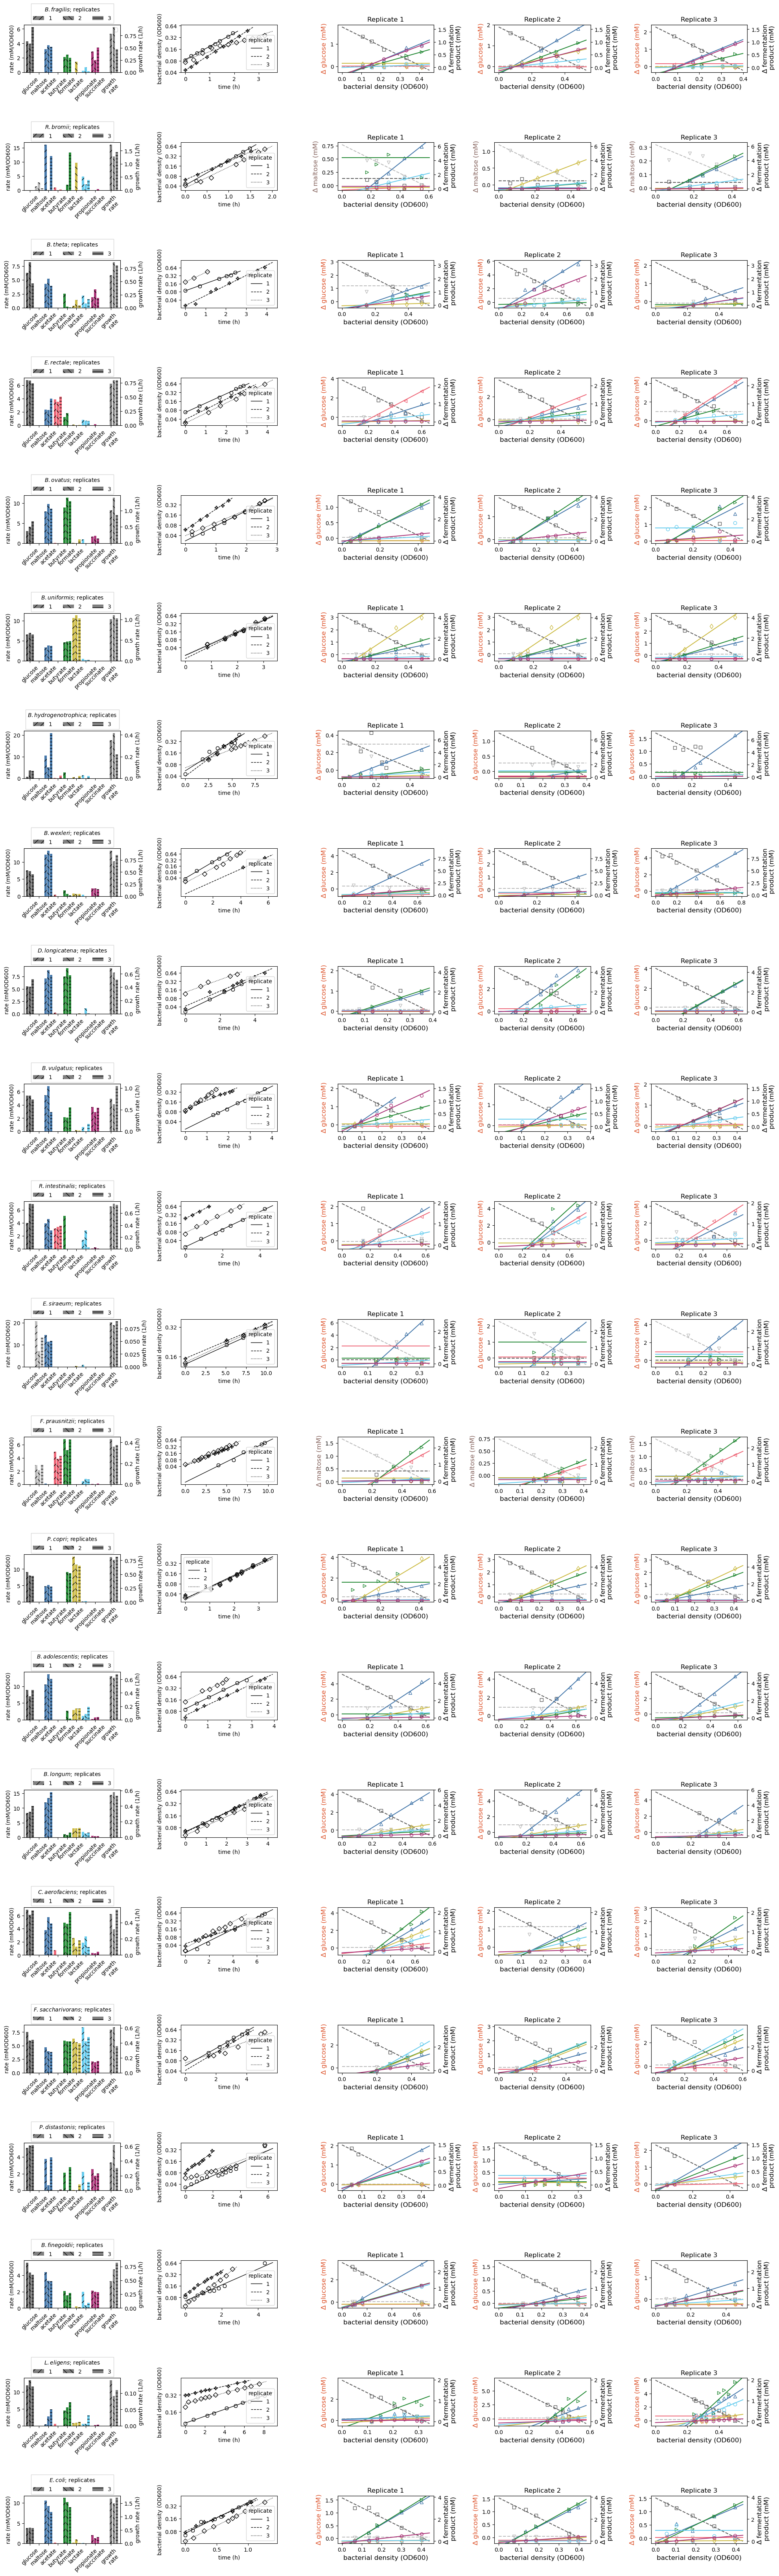

epsilon


Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  notes     strain      species  \
182           182           NaN         NaN    NaN   ATCC8492  B.uniformis   
56             56          67.0        20.0    NaN   ATCC8492  B.uniformis   
55             55          66.0        21.0    NaN   ATCC8492  B.uniformis   
54             54          65.0        22.0    NaN   ATCC8492  B.uniformis   
20             20          20.0        14.0    NaN  ATCC25285   B.fragilis   
..            ...           ...         ...    ...        ...          ...   
96             96         119.0       106.0    NaN    NCM3722       E.coli   
97             97         120.0       104.0    NaN    NCM3722       E.coli   
98             98         121.0        86.0    NaN    NCM3722       E.coli   
194           194           NaN         NaN    NaN    NCM3722       E.coli   
90             90         113.0       131.0    NaN    NCM3722       E.coli   

                                        experiment  \
182  av [25, 24, 23]_used_only: [59.0, 60.0, 61.0]   
56                  analysis_stan_YCA_230712_2.5mM   
55                  analysis_stan_YCA_230712_2.5mM   
54                  analysis_stan_YCA_230712_2.5mM   
20                  analysis_stan_YCA_230607_2.5mM   
..                                             ...   
96                                             NaN   
97                                             NaN   
98                                             NaN   
194        av [162, 150]_used_only: [111.0, 113.0]   
90                                             NaN   

                        experiment_short                   exp_number  \
182                                   av  av_B.uniformis_ATCC8492_YCA   
56        analysis_stan_YCA_230712_2.5mM                           23   
55        analysis_stan_YCA_230712_2.5mM                           24   
54        analysis_stan_YCA_230712_2.5mM                           25   
20        analysis_stan_YCA_230607_2.5mM                           17   
..                                   ...                          ...   
96         analysis_stan_eplus_Oct22.csv                          150   
97              analysis_stan_simple.csv                          146   
98   analysis_stan_eplus_wotrp_Oct22.csv                          112   
194                                   av    av_E.coli_NCM3722_epsilon   
90                      stan_BHI_30Dec22                          187   

      medium  ... succinate_std  lactate_std  butyrate_std formate_std  \
182      YCA  ...  5.682633e-16     0.417771      0.016282    0.112282   
56       YCA  ...           NaN          NaN           NaN         NaN   
55       YCA  ...           NaN          NaN           NaN         NaN   
54       YCA  ...           NaN          NaN           NaN         NaN   
20       YCA  ...           NaN          NaN           NaN         NaN   
..       ...  ...           ...          ...           ...         ...   
96   epsilon  ...           NaN          NaN           NaN         NaN   
97     gamma  ...           NaN          NaN           NaN         NaN   
98     gamma  ...           NaN          NaN           NaN         NaN   
194  epsilon  ...  5.784812e-01     0.632041      0.000000    0.371618   
90       BHI  ...           NaN          NaN           NaN         NaN   

    maltose_std total_ferm  total_ferm_std total_uptake  total_uptake_std  \
182    0.000000  19.522489        0.447882    -6.650701          0.217517   
56          NaN        NaN             NaN          NaN               NaN   
55          NaN        NaN             NaN          NaN               NaN   
54          NaN        NaN             NaN          NaN               NaN   
20          NaN        NaN             NaN          NaN               NaN   
..          ...        ...             ...          ...               ...   
96          NaN        NaN             NaN          NaN               NaN   
97          NaN        NaN           

Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  notes     strain        species  \
19             19          19.0       107.0    NaN  ATCC25285     B.fragilis   
16             16          16.0        79.0    NaN  ATCC25285     B.fragilis   
13             13          13.0       121.0    NaN  ATCC25285     B.fragilis   
38             38          38.0       110.0    NaN   ATCC8483       B.ovatus   
34             34          34.0       122.0    NaN   ATCC8483       B.ovatus   
52             52          63.0       108.0    NaN  ATCC29148        B.theta   
48             48          58.0       123.0    NaN  ATCC29148        B.theta   
41             41          47.0        80.0    NaN  ATCC29148        B.theta   
43             43          52.0        49.0   7.14  ATCC29148        B.theta   
110           110         145.0        55.0   7.14  ATCC33656      E.rectale   
103           103         130.0        69.0   7.14  ATCC33656      E.rectale   
104           104         133.0        62.0   7.14  ATCC33656      E.rectale   
114           114         151.0       111.0    NaN   DSM17677  F.prausnitzii   
148           148         204.0       113.0    NaN  ATCC27255       R.bromii   
29             29          29.0       109.0    NaN   DSM20219       B.longum   
81             81         104.0        81.0    NaN    DSM3979  C.aerofaciens   
80             80         103.0       124.0    NaN    DSM3979  C.aerofaciens   
94             94         117.0       112.0    NaN    NCM3722         E.coli   
96             96         119.0       106.0    NaN    NCM3722         E.coli   

          experiment                      experiment_short exp_number  \
19               NaN         analysis_stan_eplus_Oct22.csv        151   
16               NaN  analysis_stan_eplus_wtrp_02Sep22.csv        102   
13               NaN        analysis_stan_eplus06Sep22.csv        174   
38               NaN               analysis_stan_eplus.csv        157   
34               NaN        analysis_stan_eplus06Sep22.csv        175   
52               NaN         analysis_stan_eplus_Oct22.csv        153   
48               NaN        analysis_stan_eplus06Sep22.csv        176   
41               NaN  analysis_stan_eplus_wtrp_02Sep22.csv        104   
43    Markus_old_Bt1                        Markus_old_Bt1         62   
110   Markus_old_Er1                        Markus_old_Er1         68   
103  Markus_old_Er11                       Markus_old_Er11         82   
104   Markus_old_Er8                        Markus_old_Er8         75   
114              NaN               analysis_stan_eplus.csv        161   
148              NaN               analysis_stan_eplus.csv        164   
29               NaN               analysis_stan_eplus.csv        156   
81               NaN  analysis_stan_eplus_wtrp_02Sep22.csv        105   
80               NaN        analysis_stan_eplus06Sep22.csv        177   
94               NaN               analysis_stan_eplus.csv        162   
96               NaN         analysis_stan_eplus_Oct22.csv        150   

      medium  ... succinate_std  lactate_std  butyrate_std formate_std  \
19   epsilon  ...           NaN          NaN           NaN         NaN   
16   epsilon  ...           NaN          NaN           NaN         NaN   
13   epsilon  ...           NaN          NaN           NaN         NaN   
38   epsilon  ...           NaN          NaN           NaN         NaN   
34   epsilon  ...           NaN          NaN           NaN         NaN   
52   epsilon  ...           NaN          NaN           NaN         NaN   
48   epsilon  ...           NaN          NaN           NaN         NaN   
41   epsilon  ...           NaN          NaN           NaN         NaN   
43   epsilon  ...           NaN          NaN           NaN         NaN   
110  epsilon  ...           NaN          NaN           NaN         NaN   
103  epsilon  ...           NaN          NaN           NaN         NaN   
104  epsilon  ...           NaN          NaN           

********** Strain:
ATCC25285
['0.038', ' 0.065', ' 0.095', ' 0.121', ' 0.151', ' 0.233', ' 0.264', ' 0.365', ' nan', ' nan', ' nan']
['0.0', ' 0.65', ' 1.133333333', ' 1.583333333', ' 1.916666667', ' 2.4', ' 2.65', ' 3.033333333', ' nan', ' nan', ' nan']
['0.057', ' 0.065', ' 0.09', ' 0.107', ' 0.124', ' 0.186', ' 0.238', ' 0.294', ' 0.406', ' nan', ' nan', ' nan']
['0.0', ' 0.783333333', ' 1.583333333', ' 2.2', ' 2.583333333', ' 3.416666667', ' 3.75', ' 4.116666667', ' 4.766666667', ' nan', ' nan', ' nan']
['0.057', ' 0.065', ' 0.09', ' 0.107', ' 0.124', ' 0.186', ' 0.238', ' 0.294', ' 0.406', ' nan', ' nan', ' nan']
['0.0', ' 0.783333333', ' 1.583333333', ' 2.2', ' 2.583333333', ' 3.416666667', ' 3.75', ' 4.116666667', ' 4.766666667', ' nan', ' nan', ' nan']
[[4.4423973520135815, 3.1416880400731673, 3.1416880400731673], [-0.0, -0.0, -0.0], [2.48429358967283, 5.425514087136122, 5.425514087136122], [], [1.492936161605513], [0.0, 0.2355217334881658, 0.2355217334881658], [0.0, 0.21393388

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


********** Strain:
NCM3722
['0.064', ' 0.072', ' 0.091', ' 0.16', ' 0.272', ' 0.46', ' nan', ' nan', ' nan', ' nan', ' nan', ' nan']
['0.0', ' 0.316666667', ' 0.633333333', ' 1.1', ' 1.55', ' 1.983333333', ' nan', ' nan', ' nan', ' nan', ' nan', ' nan']
['0.045', ' 0.072', ' 0.1', ' 0.159', ' 0.183', ' 0.267', ' 0.31', ' 0.38', ' 0.4', ' nan', ' nan']
['0.0', ' 0.283333333', ' 0.45', ' 0.666666667', ' 0.766666667', ' 1.0', ' 1.083333333', ' 1.216666667', ' 1.266666667', ' nan', ' nan']
[[5.846958543562742, 5.059175151266734], [0.0400915004265854, -0.0], [8.342828374941591, 7.201736556864664], [], [10.87878851800522, 10.353240957781194], [0.1272261161839078, 1.0210667910644404], [0.0, 0.0], [2.0033750123828105, 1.1852790710337715]]


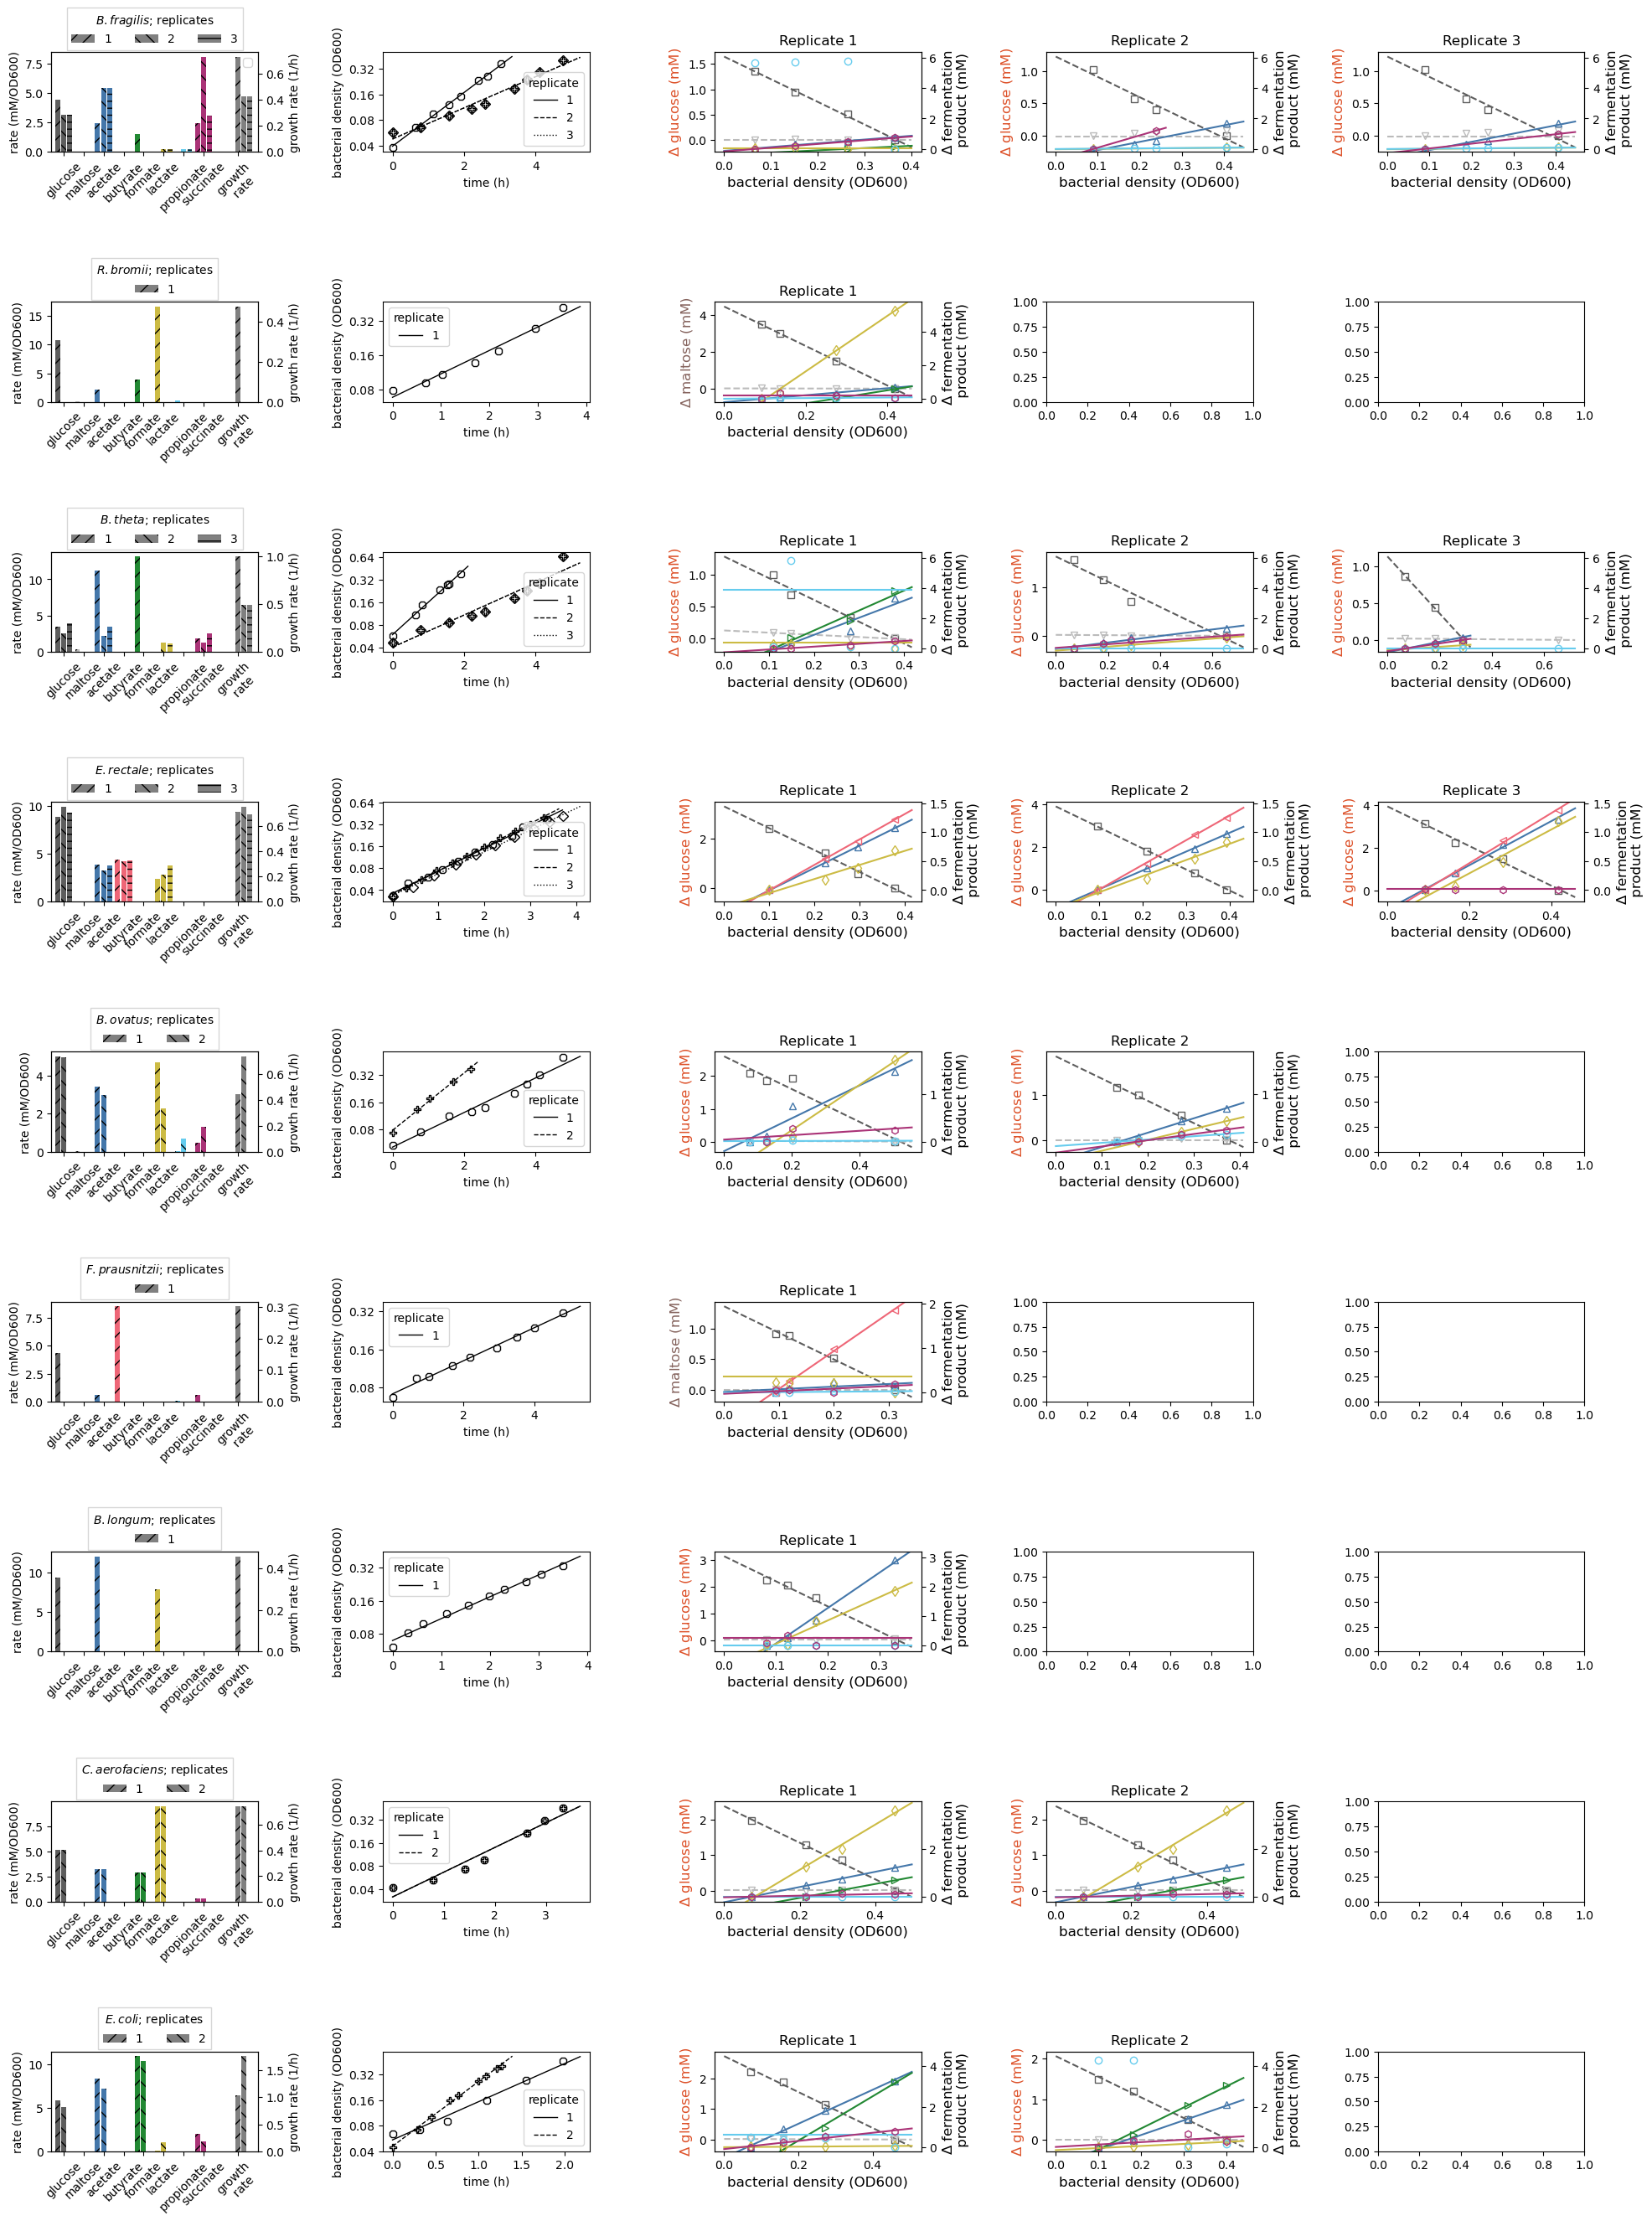

BHI


Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  notes     strain      species  \
182           182           NaN         NaN    NaN   ATCC8492  B.uniformis   
56             56          67.0        20.0    NaN   ATCC8492  B.uniformis   
55             55          66.0        21.0    NaN   ATCC8492  B.uniformis   
54             54          65.0        22.0    NaN   ATCC8492  B.uniformis   
20             20          20.0        14.0    NaN  ATCC25285   B.fragilis   
..            ...           ...         ...    ...        ...          ...   
96             96         119.0       106.0    NaN    NCM3722       E.coli   
97             97         120.0       104.0    NaN    NCM3722       E.coli   
98             98         121.0        86.0    NaN    NCM3722       E.coli   
194           194           NaN         NaN    NaN    NCM3722       E.coli   
90             90         113.0       131.0    NaN    NCM3722       E.coli   

                                        experiment  \
182  av [25, 24, 23]_used_only: [59.0, 60.0, 61.0]   
56                  analysis_stan_YCA_230712_2.5mM   
55                  analysis_stan_YCA_230712_2.5mM   
54                  analysis_stan_YCA_230712_2.5mM   
20                  analysis_stan_YCA_230607_2.5mM   
..                                             ...   
96                                             NaN   
97                                             NaN   
98                                             NaN   
194        av [162, 150]_used_only: [111.0, 113.0]   
90                                             NaN   

                        experiment_short                   exp_number  \
182                                   av  av_B.uniformis_ATCC8492_YCA   
56        analysis_stan_YCA_230712_2.5mM                           23   
55        analysis_stan_YCA_230712_2.5mM                           24   
54        analysis_stan_YCA_230712_2.5mM                           25   
20        analysis_stan_YCA_230607_2.5mM                           17   
..                                   ...                          ...   
96         analysis_stan_eplus_Oct22.csv                          150   
97              analysis_stan_simple.csv                          146   
98   analysis_stan_eplus_wotrp_Oct22.csv                          112   
194                                   av    av_E.coli_NCM3722_epsilon   
90                      stan_BHI_30Dec22                          187   

      medium  ... succinate_std  lactate_std  butyrate_std formate_std  \
182      YCA  ...  5.682633e-16     0.417771      0.016282    0.112282   
56       YCA  ...           NaN          NaN           NaN         NaN   
55       YCA  ...           NaN          NaN           NaN         NaN   
54       YCA  ...           NaN          NaN           NaN         NaN   
20       YCA  ...           NaN          NaN           NaN         NaN   
..       ...  ...           ...          ...           ...         ...   
96   epsilon  ...           NaN          NaN           NaN         NaN   
97     gamma  ...           NaN          NaN           NaN         NaN   
98     gamma  ...           NaN          NaN           NaN         NaN   
194  epsilon  ...  5.784812e-01     0.632041      0.000000    0.371618   
90       BHI  ...           NaN          NaN           NaN         NaN   

    maltose_std total_ferm  total_ferm_std total_uptake  total_uptake_std  \
182    0.000000  19.522489        0.447882    -6.650701          0.217517   
56          NaN        NaN             NaN          NaN               NaN   
55          NaN        NaN             NaN          NaN               NaN   
54          NaN        NaN             NaN          NaN               NaN   
20          NaN        NaN             NaN          NaN               NaN   
..          ...        ...             ...          ...               ...   
96          NaN        NaN             NaN          NaN               NaN   
97          NaN        NaN           

Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  notes     strain         species  \
15             15          15.0       139.0    NaN  ATCC25285      B.fragilis   
11             11          11.0       138.0    NaN  ATCC25285      B.fragilis   
32             32          32.0       134.0    NaN   ATCC8483        B.ovatus   
33             33          33.0       135.0    NaN   ATCC8483        B.ovatus   
39             39          39.0       115.0    NaN   ATCC8483        B.ovatus   
45             45          54.0       133.0    NaN  ATCC29148         B.theta   
46             46          55.0       132.0    NaN  ATCC29148         B.theta   
51             51          62.0       116.0    NaN  ATCC29148         B.theta   
5               5           5.0       114.0    NaN     HM-727    B.finegoldii   
9               9           9.0        90.0    NaN     HM-727    B.finegoldii   
8               8           8.0        89.0    NaN     HM-727    B.finegoldii   
63             63          74.0        92.0    NaN   DSM 1447      B.vulgatus   
61             61          72.0       144.0    NaN   DSM 1447      B.vulgatus   
62             62          73.0       145.0    NaN   DSM 1447      B.vulgatus   
58             58          69.0       117.0    NaN   DSM 1447      B.vulgatus   
57             57          68.0        91.0    NaN   DSM 1447      B.vulgatus   
145           145         200.0        96.0    NaN     HM-169   P.distastonis   
140           140         195.0       120.0    NaN     HM-169   P.distastonis   
147           147         202.0       119.0    NaN     HM-169   P.distastonis   
146           146         201.0        95.0    NaN     HM-169   P.distastonis   
157           157         218.0        84.0    NaN   DSM14610  R.intestinalis   
162           162         223.0       103.0    NaN   DSM14610  R.intestinalis   
156           156         217.0        85.0    NaN   DSM14610  R.intestinalis   
106           106         140.0        97.0    NaN  ATCC33656       E.rectale   
107           107         141.0        98.0    NaN  ATCC33656       E.rectale   
102           102         128.0        83.0    NaN  ATCC33656       E.rectale   
101           101         127.0       140.0    NaN  ATCC33656       E.rectale   
100           100         126.0       141.0    NaN  ATCC33656       E.rectale   
99             99         125.0        82.0    NaN  ATCC33656       E.rectale   
118           118         165.0        93.0    NaN   DSM17677   F.prausnitzii   
119           119         167.0        99.0    NaN   DSM17677   F.prausnitzii   
120           120         168.0       101.0    NaN   DSM17677   F.prausnitzii   
121           121         170.0        94.0    NaN   DSM17677   F.prausnitzii   
30             30          30.0       136.0    NaN   DSM20219        B.longum   
31             31          31.0       137.0    NaN   DSM20219        B.longum   
4               4           4.0       142.0    NaN   DSM20083  B.adolescentis   
3               3           3.0       143.0    NaN   DSM20083  B.adolescentis   
75             75          98.0       102.0    NaN    DSM3979   C.aerofaciens   
82             82         105.0       100.0    NaN    DSM3979   C.aerofaciens   
89             89         112.0       130.0    NaN    NCM3722          E.coli   
92             92         115.0       118.0    NaN    NCM3722          E.coli   
90             90         113.0       131.0    NaN    NCM3722          E.coli   

    experiment                         experiment_short exp_number medium  \
15         NaN                         stan_BHI_30Dec22        195    BHI   
11         NaN                         stan_BHI_30Dec22        194    BHI   
32         NaN                         stan_BHI_30Dec22        190    BHI   
33         NaN                         stan_BHI_30Dec22        191    BHI   
39         NaN        analysis_stan_BHI_2.5mM_Feb23.csv        168    BHI   
45         NaN                         stan_BHI_30Dec22    

********** Strain:
ATCC25285
['0.034', ' 0.087', ' 0.179', ' 0.33', ' 0.371', ' 0.408', ' nan', ' nan', ' nan', ' nan']
['0.0', ' 0.466666667', ' 0.783333333', ' 0.916666667', ' 1.133333333', ' 1.216666667', ' nan', ' nan', ' nan', ' nan']
['0.03', ' 0.041', ' 0.049', ' 0.059', ' 0.064', ' 0.093', ' 0.113', ' 0.135', ' 0.174', ' 0.191']
['0.0', ' 0.133333333', ' 0.5', ' 0.616666667', ' 0.8', ' 1.1', ' 1.4', ' 1.616666667', ' 1.95', ' 2.166666667']
[[2.132601775782359, 2.3245169469855465], [-0.0, -0.0], [12.93495811849932, 5.129150578532806], [], [9.300669385050748, 2.9370532226524286], [0.3923727046487709, 1.0979012325807185], [1.1913120961385206, 0.0], [1.568255319994529, 3.1491236138892926]]
********** Strain:
ATCC29148
['0.042', ' 0.083', ' 0.11', ' 0.157', ' 0.194', ' 0.258', ' 0.323', ' 0.398', ' nan', ' nan']
['0.0', ' 0.383333333', ' 0.516666667', ' 0.716666667', ' 0.8', ' 0.966666667', ' 1.133333333', ' 1.3', ' nan', ' nan']
['0.032', ' 0.065', ' 0.094', ' 0.131', ' 0.159', ' 0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


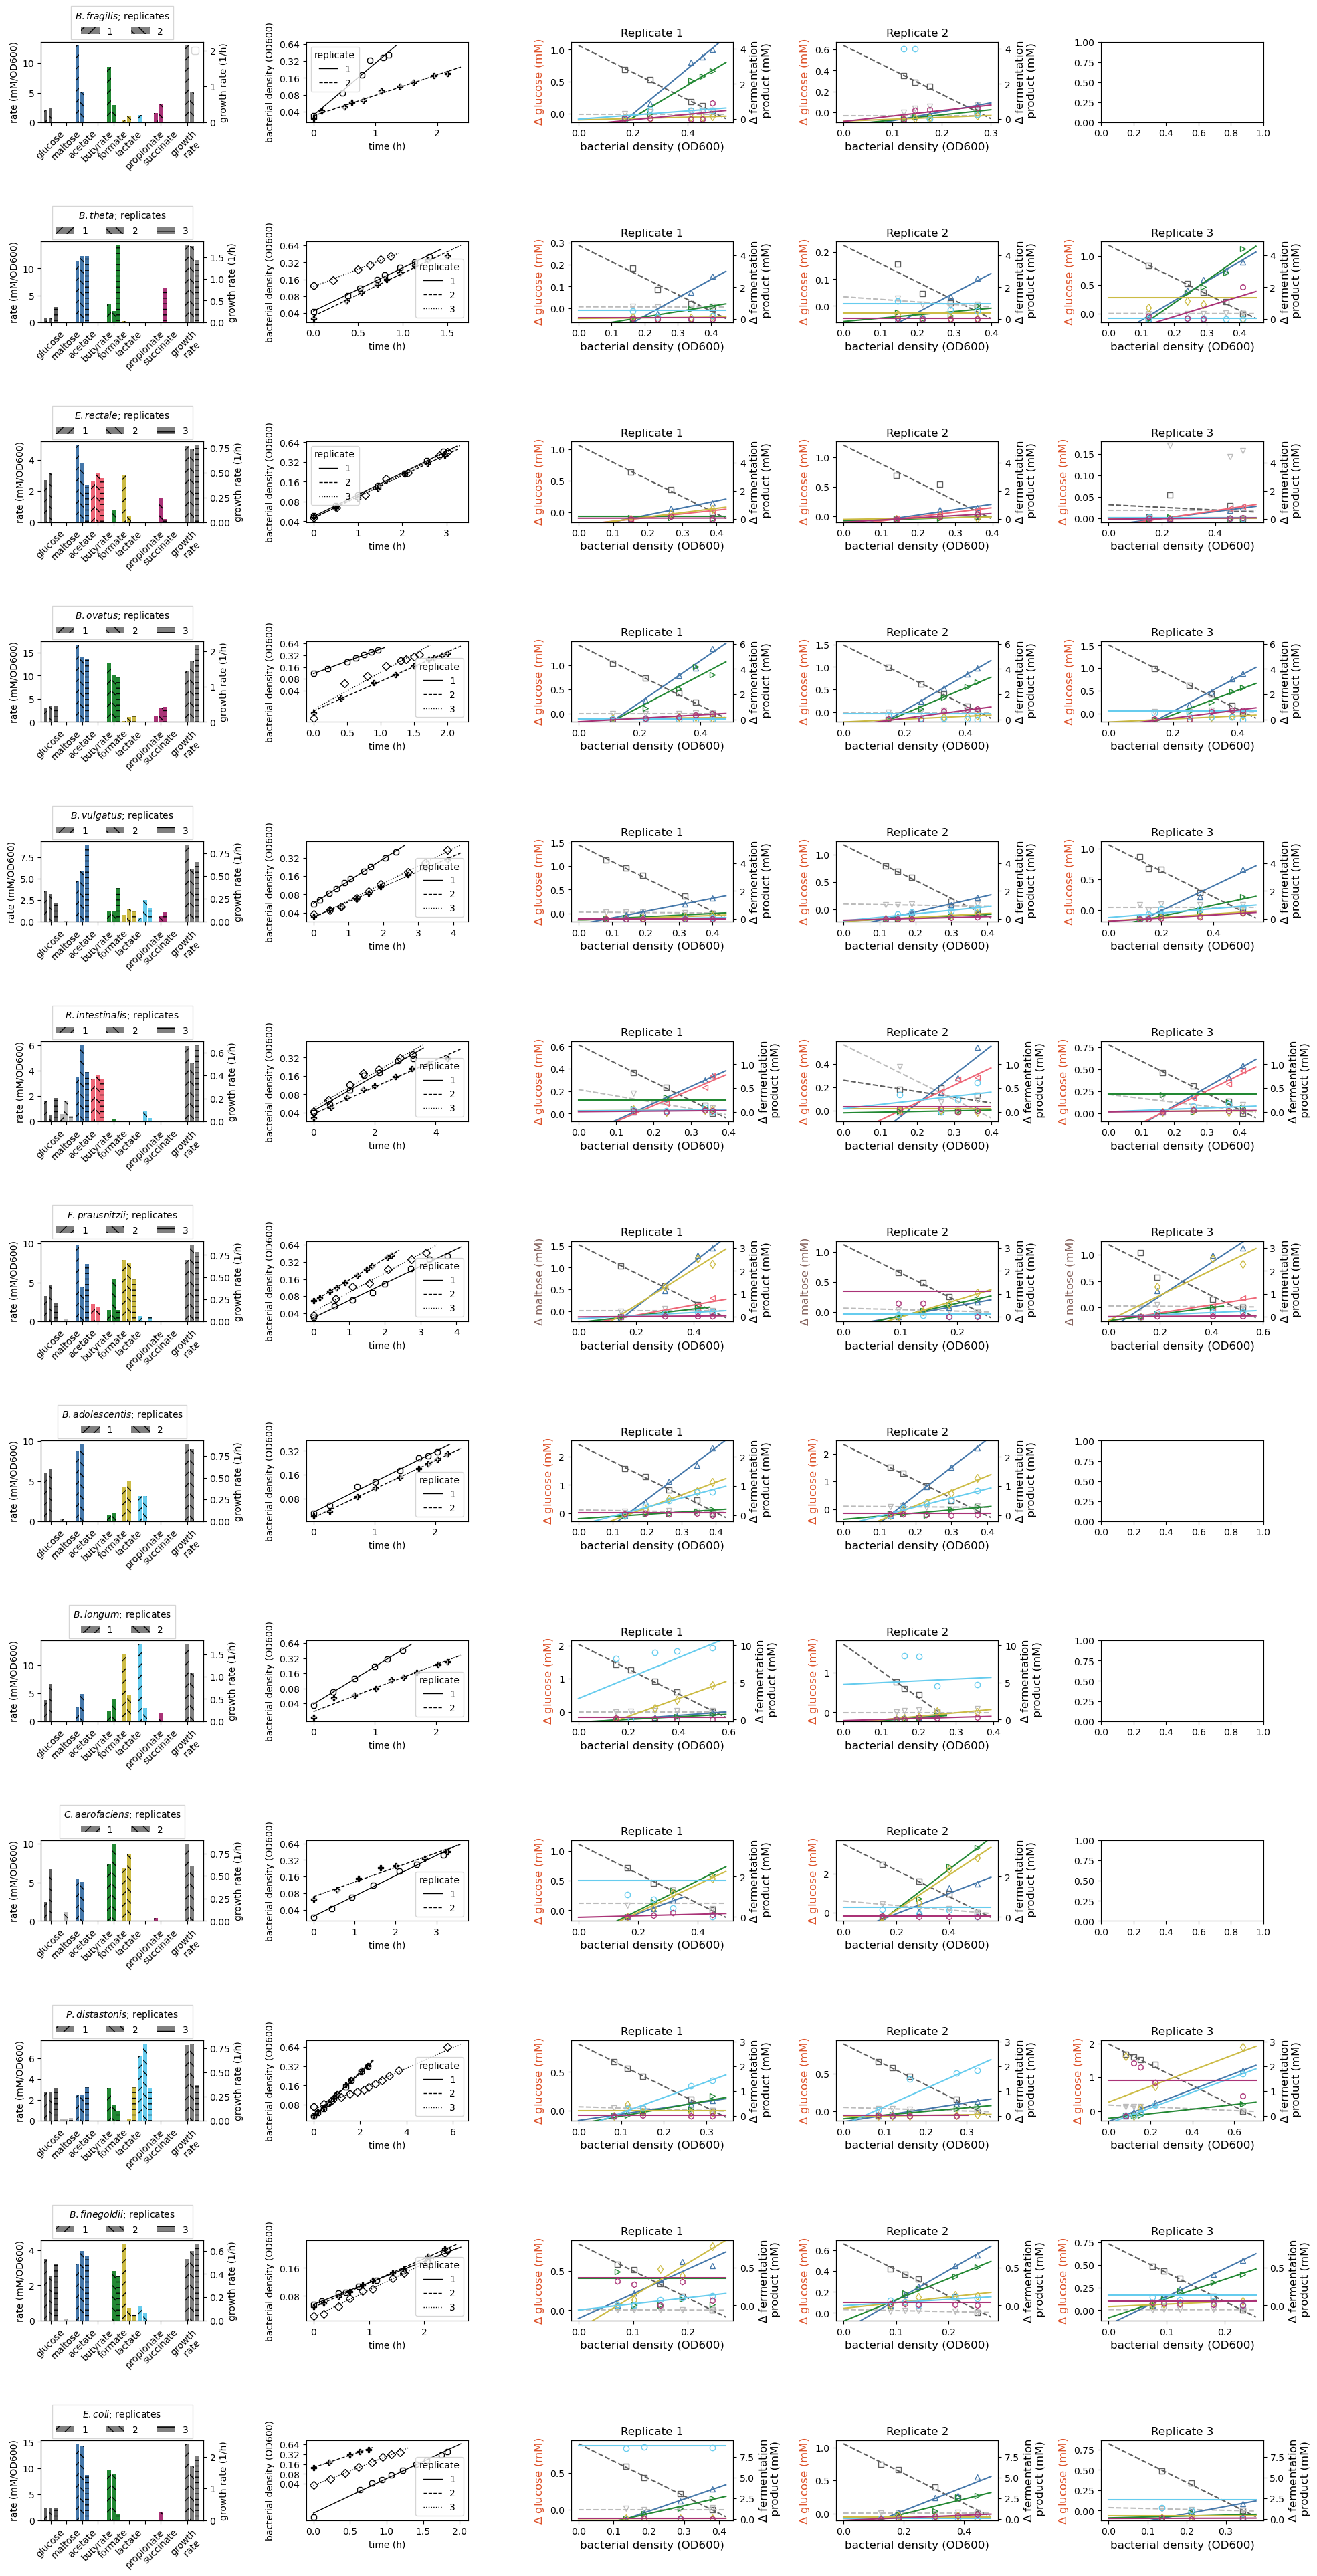

gamma


Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  notes     strain      species  \
182           182           NaN         NaN    NaN   ATCC8492  B.uniformis   
56             56          67.0        20.0    NaN   ATCC8492  B.uniformis   
55             55          66.0        21.0    NaN   ATCC8492  B.uniformis   
54             54          65.0        22.0    NaN   ATCC8492  B.uniformis   
20             20          20.0        14.0    NaN  ATCC25285   B.fragilis   
..            ...           ...         ...    ...        ...          ...   
96             96         119.0       106.0    NaN    NCM3722       E.coli   
97             97         120.0       104.0    NaN    NCM3722       E.coli   
98             98         121.0        86.0    NaN    NCM3722       E.coli   
194           194           NaN         NaN    NaN    NCM3722       E.coli   
90             90         113.0       131.0    NaN    NCM3722       E.coli   

                                        experiment  \
182  av [25, 24, 23]_used_only: [59.0, 60.0, 61.0]   
56                  analysis_stan_YCA_230712_2.5mM   
55                  analysis_stan_YCA_230712_2.5mM   
54                  analysis_stan_YCA_230712_2.5mM   
20                  analysis_stan_YCA_230607_2.5mM   
..                                             ...   
96                                             NaN   
97                                             NaN   
98                                             NaN   
194        av [162, 150]_used_only: [111.0, 113.0]   
90                                             NaN   

                        experiment_short                   exp_number  \
182                                   av  av_B.uniformis_ATCC8492_YCA   
56        analysis_stan_YCA_230712_2.5mM                           23   
55        analysis_stan_YCA_230712_2.5mM                           24   
54        analysis_stan_YCA_230712_2.5mM                           25   
20        analysis_stan_YCA_230607_2.5mM                           17   
..                                   ...                          ...   
96         analysis_stan_eplus_Oct22.csv                          150   
97              analysis_stan_simple.csv                          146   
98   analysis_stan_eplus_wotrp_Oct22.csv                          112   
194                                   av    av_E.coli_NCM3722_epsilon   
90                      stan_BHI_30Dec22                          187   

      medium  ... succinate_std  lactate_std  butyrate_std formate_std  \
182      YCA  ...  5.682633e-16     0.417771      0.016282    0.112282   
56       YCA  ...           NaN          NaN           NaN         NaN   
55       YCA  ...           NaN          NaN           NaN         NaN   
54       YCA  ...           NaN          NaN           NaN         NaN   
20       YCA  ...           NaN          NaN           NaN         NaN   
..       ...  ...           ...          ...           ...         ...   
96   epsilon  ...           NaN          NaN           NaN         NaN   
97     gamma  ...           NaN          NaN           NaN         NaN   
98     gamma  ...           NaN          NaN           NaN         NaN   
194  epsilon  ...  5.784812e-01     0.632041      0.000000    0.371618   
90       BHI  ...           NaN          NaN           NaN         NaN   

    maltose_std total_ferm  total_ferm_std total_uptake  total_uptake_std  \
182    0.000000  19.522489        0.447882    -6.650701          0.217517   
56          NaN        NaN             NaN          NaN               NaN   
55          NaN        NaN             NaN          NaN               NaN   
54          NaN        NaN             NaN          NaN               NaN   
20          NaN        NaN             NaN          NaN               NaN   
..          ...        ...             ...          ...               ...   
96          NaN        NaN             NaN          NaN               NaN   
97          NaN        NaN           

Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  notes     strain     species  \
12            12          12.0       105.0    NaN  ATCC25285  B.fragilis   
14            14          14.0        87.0    NaN  ATCC25285  B.fragilis   
42            42          49.0        88.0    NaN  ATCC29148     B.theta   
49            49          60.0       147.0    NaN  ATCC29148     B.theta   
44            44          53.0       146.0    NaN  ATCC29148     B.theta   
65            65          76.0       148.0    NaN   DSM 1447  B.vulgatus   
60            60          71.0       149.0    NaN   DSM 1447  B.vulgatus   
87            87         110.0       151.0    NaN    NCM3722      E.coli   
88            88         111.0       150.0    NaN    NCM3722      E.coli   
97            97         120.0       104.0    NaN    NCM3722      E.coli   
98            98         121.0        86.0    NaN    NCM3722      E.coli   

   experiment                     experiment_short exp_number medium  ...  \
12        NaN             analysis_stan_simple.csv        147  gamma  ...   
14        NaN  analysis_stan_eplus_wotrp_Oct22.csv        113  gamma  ...   
42        NaN  analysis_stan_eplus_wotrp_Oct22.csv        115  gamma  ...   
49        NaN      stan_simple_medium_230908_2.5mM        203  gamma  ...   
44        NaN      stan_simple_medium_230908_2.5mM        202  gamma  ...   
65        NaN      stan_simple_medium_230908_2.5mM        204  gamma  ...   
60        NaN      stan_simple_medium_230908_2.5mM        205  gamma  ...   
87        NaN      stan_simple_medium_230908_2.5mM        207  gamma  ...   
88        NaN      stan_simple_medium_230908_2.5mM        206  gamma  ...   
97        NaN             analysis_stan_simple.csv        146  gamma  ...   
98        NaN  analysis_stan_eplus_wotrp_Oct22.csv        112  gamma  ...   

   succinate_std  lactate_std  butyrate_std formate_std maltose_std  \
12           NaN          NaN           NaN         NaN         NaN   
14           NaN          NaN           NaN         NaN         NaN   
42           NaN          NaN           NaN         NaN         NaN   
49           NaN          NaN           NaN         NaN         NaN   
44           NaN          NaN           NaN         NaN         NaN   
65           NaN          NaN           NaN         NaN         NaN   
60           NaN          NaN           NaN         NaN         NaN   
87           NaN          NaN           NaN         NaN         NaN   
88           NaN          NaN           NaN         NaN         NaN   
97           NaN          NaN           NaN         NaN         NaN   
98           NaN          NaN           NaN         NaN         NaN   

   total_ferm  total_ferm_std total_uptake  total_uptake_std  growth_rate_std  
12        NaN             NaN          NaN               NaN              NaN  
14        NaN             NaN          NaN               NaN              NaN  
42        NaN             NaN          NaN               NaN              NaN  
49        NaN             NaN          NaN               NaN              NaN  
44        NaN             NaN          NaN               NaN              NaN  
65        NaN             NaN          NaN               NaN              NaN  
60        NaN             NaN          NaN               NaN              NaN  
87        NaN             NaN          NaN               NaN              NaN  
88        NaN             NaN          NaN               NaN              NaN  
97        NaN             NaN          NaN               NaN              NaN  
98        NaN             NaN          NaN               NaN              NaN  

[11 rows x 65 columns]

********** Strain:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



ATCC25285
['0.064', ' 0.08', ' 0.126', ' 0.149', ' 0.17', ' 0.254', ' 0.368', ' nan', ' nan', ' nan', ' nan']
['0.0', ' 0.416666667', ' 0.9', ' 1.566666667', ' 1.683333333', ' 3.25', ' 3.9', ' nan', ' nan', ' nan', ' nan']
['0.061', ' 0.072', ' 0.085', ' 0.097', ' 0.111', ' 0.128', ' 0.139', ' 0.157', ' 0.192', ' 0.211', ' 0.227', ' 0.33']
['0.0', ' 0.683333333', ' 1.133333333', ' 1.45', ' 1.766666667', ' 2.383333333', ' 2.683333333', ' 3.016666667', ' 3.65', ' 3.916666667', ' 4.15', ' 5.3']
[[5.181692195386106, 7.469686635309559], [0.0324430104768542], [3.218658170402831, 4.782880888216051], [], [2.793164899410476, 5.92696425490033], [0.3429240773660639, 0.7668649623122943], [1.3856185193911097, 2.26978592092665], [0.3675764861352726, 0.1822888909204918]]
********** Strain:
ATCC29148
['0.057', ' 0.086', ' 0.104', ' 0.117', ' 0.134', ' 0.174', ' 0.197', ' 0.234', ' 0.29', ' 0.332', ' 0.368', ' nan']
['0.0', ' 0.683333333', ' 1.133333333', ' 1.45', ' 1.766666667', ' 2.383333333', ' 2.6

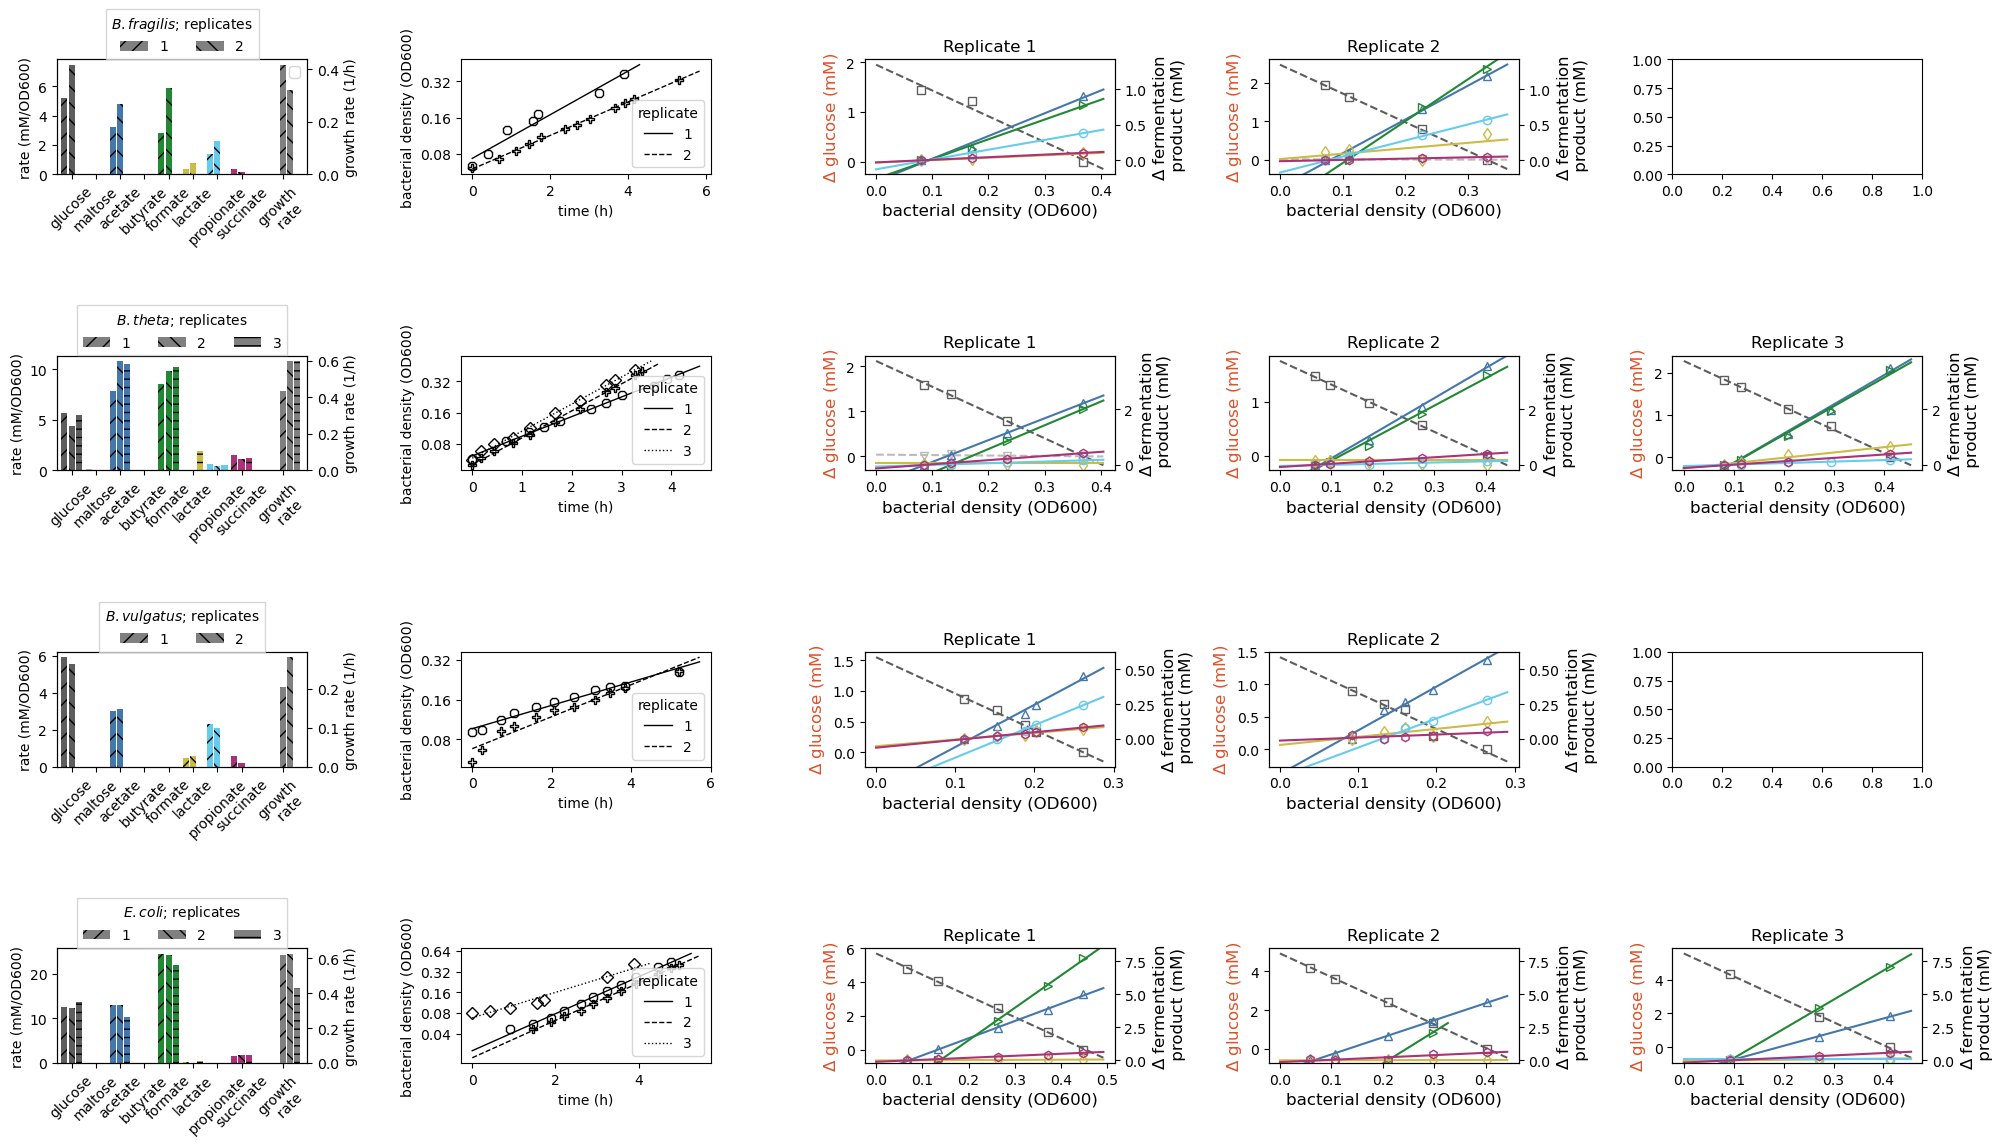

pHvar


Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  notes     strain      species  \
182           182           NaN         NaN    NaN   ATCC8492  B.uniformis   
56             56          67.0        20.0    NaN   ATCC8492  B.uniformis   
55             55          66.0        21.0    NaN   ATCC8492  B.uniformis   
54             54          65.0        22.0    NaN   ATCC8492  B.uniformis   
20             20          20.0        14.0    NaN  ATCC25285   B.fragilis   
..            ...           ...         ...    ...        ...          ...   
96             96         119.0       106.0    NaN    NCM3722       E.coli   
97             97         120.0       104.0    NaN    NCM3722       E.coli   
98             98         121.0        86.0    NaN    NCM3722       E.coli   
194           194           NaN         NaN    NaN    NCM3722       E.coli   
90             90         113.0       131.0    NaN    NCM3722       E.coli   

                                        experiment  \
182  av [25, 24, 23]_used_only: [59.0, 60.0, 61.0]   
56                  analysis_stan_YCA_230712_2.5mM   
55                  analysis_stan_YCA_230712_2.5mM   
54                  analysis_stan_YCA_230712_2.5mM   
20                  analysis_stan_YCA_230607_2.5mM   
..                                             ...   
96                                             NaN   
97                                             NaN   
98                                             NaN   
194        av [162, 150]_used_only: [111.0, 113.0]   
90                                             NaN   

                        experiment_short                   exp_number  \
182                                   av  av_B.uniformis_ATCC8492_YCA   
56        analysis_stan_YCA_230712_2.5mM                           23   
55        analysis_stan_YCA_230712_2.5mM                           24   
54        analysis_stan_YCA_230712_2.5mM                           25   
20        analysis_stan_YCA_230607_2.5mM                           17   
..                                   ...                          ...   
96         analysis_stan_eplus_Oct22.csv                          150   
97              analysis_stan_simple.csv                          146   
98   analysis_stan_eplus_wotrp_Oct22.csv                          112   
194                                   av    av_E.coli_NCM3722_epsilon   
90                      stan_BHI_30Dec22                          187   

      medium  ... succinate_std  lactate_std  butyrate_std formate_std  \
182      YCA  ...  5.682633e-16     0.417771      0.016282    0.112282   
56       YCA  ...           NaN          NaN           NaN         NaN   
55       YCA  ...           NaN          NaN           NaN         NaN   
54       YCA  ...           NaN          NaN           NaN         NaN   
20       YCA  ...           NaN          NaN           NaN         NaN   
..       ...  ...           ...          ...           ...         ...   
96   epsilon  ...           NaN          NaN           NaN         NaN   
97     gamma  ...           NaN          NaN           NaN         NaN   
98     gamma  ...           NaN          NaN           NaN         NaN   
194  epsilon  ...  5.784812e-01     0.632041      0.000000    0.371618   
90       BHI  ...           NaN          NaN           NaN         NaN   

    maltose_std total_ferm  total_ferm_std total_uptake  total_uptake_std  \
182    0.000000  19.522489        0.447882    -6.650701          0.217517   
56          NaN        NaN             NaN          NaN               NaN   
55          NaN        NaN             NaN          NaN               NaN   
54          NaN        NaN             NaN          NaN               NaN   
20          NaN        NaN             NaN          NaN               NaN   
..          ...        ...             ...          ...               ...   
96          NaN        NaN             NaN          NaN               NaN   
97          NaN        NaN           

Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  notes     strain     species  \
66             66          81.0       178.0   7.00   DSM 1447  B.vulgatus   
69             69          92.0       180.0   7.00   DSM 1447  B.vulgatus   
67             67          89.0       179.0   7.00   DSM 1447  B.vulgatus   
136           136         185.0       218.0   7.15   DSM18205     P.copri   
135           135         184.0       217.0   7.15   DSM18205     P.copri   
151           151         208.0       220.0   7.15  ATCC27255    R.bromii   
150           150         207.0       219.0   7.15  ATCC27255    R.bromii   

    experiment                  experiment_short exp_number medium  ...  \
66         NaN    hplc_analysis_revisions_zurich        234  pHvar  ...   
69         NaN    hplc_analysis_revisions_zurich        236  pHvar  ...   
67         NaN    hplc_analysis_revisions_zurich        235  pHvar  ...   
136        NaN  hplc_analysis_revisions_stanford        286  pHvar  ...   
135        NaN  hplc_analysis_revisions_stanford        285  pHvar  ...   
151        NaN  hplc_analysis_revisions_stanford        289  pHvar  ...   
150        NaN  hplc_analysis_revisions_stanford        288  pHvar  ...   

    succinate_std  lactate_std  butyrate_std formate_std maltose_std  \
66            NaN          NaN           NaN         NaN         NaN   
69            NaN          NaN           NaN         NaN         NaN   
67            NaN          NaN           NaN         NaN         NaN   
136           NaN          NaN           NaN         NaN         NaN   
135           NaN          NaN           NaN         NaN         NaN   
151           NaN          NaN           NaN         NaN         NaN   
150           NaN          NaN           NaN         NaN         NaN   

    total_ferm  total_ferm_std total_uptake  total_uptake_std  growth_rate_std  
66         NaN             NaN          NaN               NaN              NaN  
69         NaN             NaN          NaN               NaN              NaN  
67         NaN             NaN          NaN               NaN              NaN  
136        NaN             NaN          NaN               NaN              NaN  
135        NaN             NaN          NaN               NaN              NaN  
151        NaN             NaN          NaN               NaN              NaN  
150        NaN             NaN          NaN               NaN              NaN  

[7 rows x 65 columns]

********** Strain:
ATCC27255
['0.122', ' 0.206', ' 0.351', ' 0.466', ' nan', ' nan', ' nan', ' nan', ' nan', ' nan', ' nan', ' nan']
['0.0', ' 0.33', ' 0.77', ' 1.05', ' nan', ' nan', ' nan', ' nan', ' nan', ' nan', ' nan', ' nan']
['0.145', ' 0.228', ' 0.39', ' 0.543', ' nan', ' nan', ' nan', ' nan', ' nan', ' nan', ' nan', ' nan']
['0.0', ' 0.33', ' 0.77', ' 1.05', ' nan', ' nan', ' nan', ' nan', ' nan', ' nan', ' nan', ' nan']
[[-0.0, -0.0], [2.708688441094541, 2.8246437476550934], [0.0, 0.0], [], [2.166405618001809, 2.1508257849368326], [11.924611316467397, 13.30065618883901], [2.22650619146166, 2.162905548331828], [0.0, 0.0]]
********** Strain:
DSM 1447
['0.208', ' 0.268', ' 0.353', ' 0.455', ' 0.567', ' nan', ' nan', ' nan']
['0.0', ' 0.316666667', ' 0.7', ' 1.033333333', ' 1.366666667', ' nan', ' nan', ' nan']
['0.216', ' 0.289', ' 0.375', ' 0.489', ' 0.623', ' nan', ' nan', ' nan']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



['0.0', ' 0.333333333', ' 0.716666667', ' 1.05', ' 1.383333333', ' nan', ' nan', ' nan']
['0.211', ' 0.273', ' 0.372', ' 0.464', ' 0.596', ' nan', ' nan', ' nan']
['0.0', ' 0.316666667', ' 0.7', ' 1.033333333', ' 1.366666667', ' nan', ' nan', ' nan']
[[5.353619605345108, 5.558756786376447, 5.193079232799374], [0.0011487531239162, 0.1044318458910061, -0.0], [5.296065469329356, 5.339045435642557, 5.6232471360199305], [2.3908716760737265, 1.7152376792465889], [1.753834248792728, 1.6356711211992814, 2.6594704144326684], [], [1.4502220051770711, 1.471052932752883, 1.476421349622555], [0.0, 2.3794711323100715, 0.0]]
********** Strain:
DSM18205
['0.042', ' 0.067', ' 0.16', ' 0.249', ' 0.328', ' 0.468', ' nan', ' nan', ' nan', ' nan', ' nan', ' nan']
['0.0', ' 0.3', ' 0.62', ' 0.83', ' 0.97', ' 1.17', ' nan', ' nan', ' nan', ' nan', ' nan', ' nan']
['nan', ' nan', ' nan', ' 0.051', ' 0.116', ' 0.235', ' 0.372', ' 0.468', ' nan', ' nan', ' nan', ' nan']
['0.0', ' 0.3', ' 0.88', ' 1.53', ' 1.83

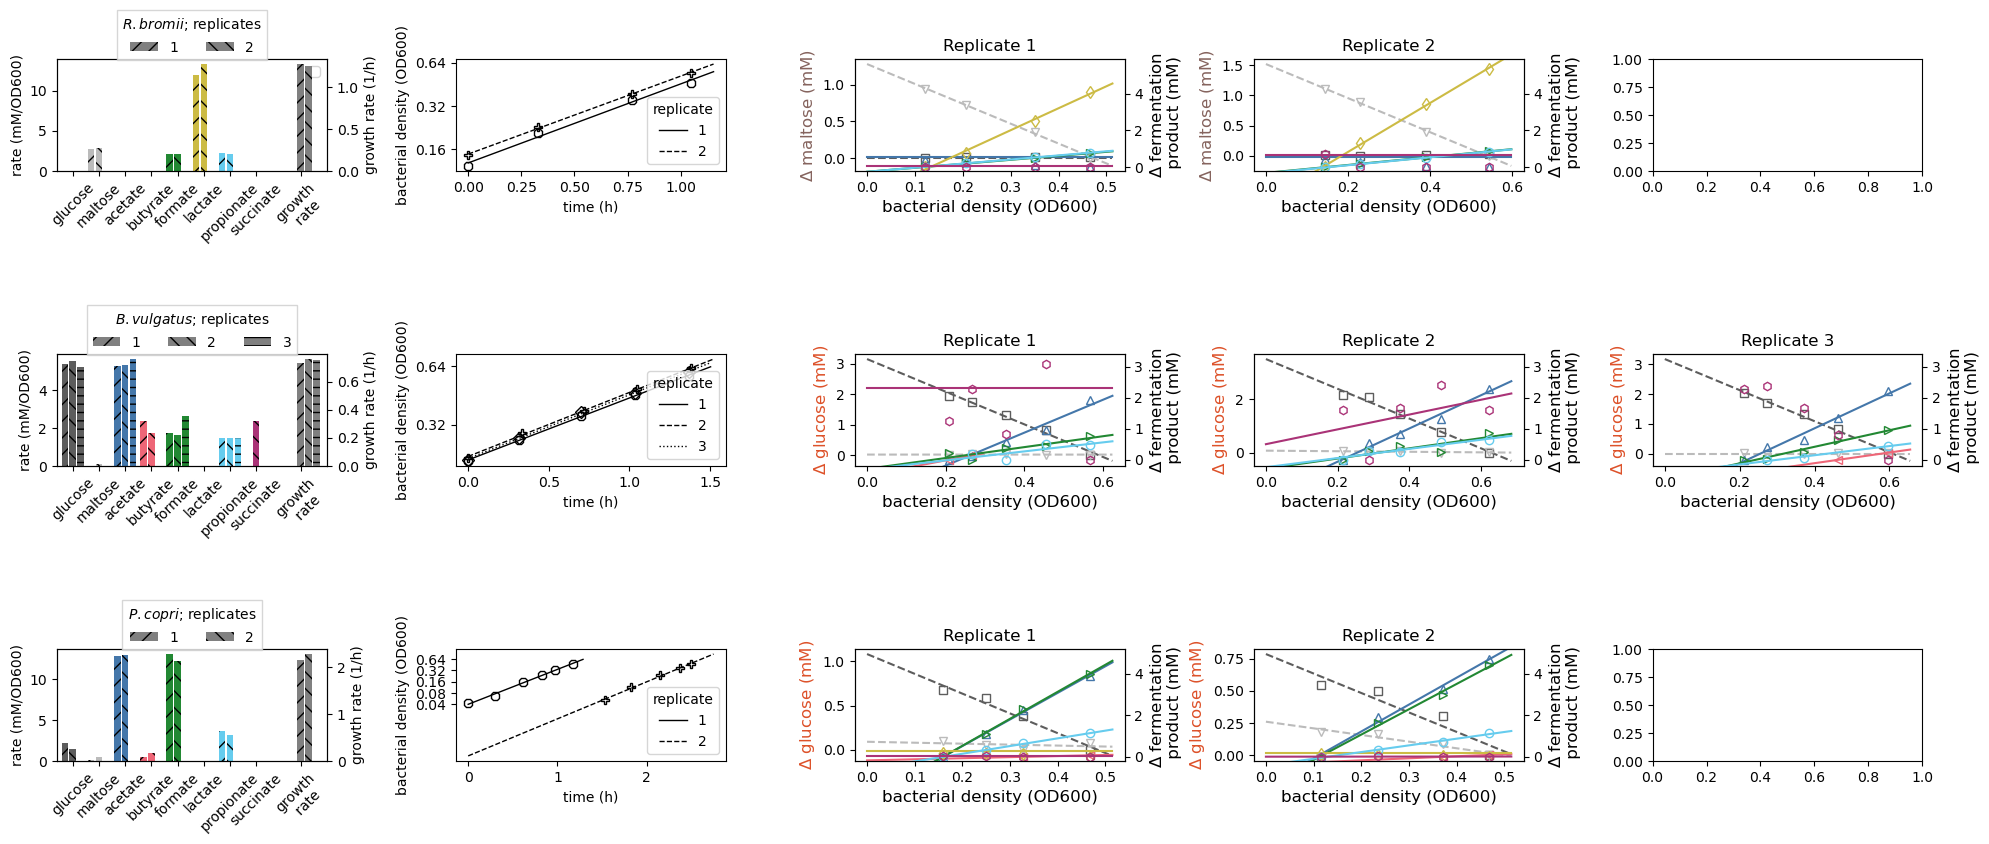

In [27]:

#plot concentration vs OD
####################

print(dataout_av["medium"].unique())
for medium in media:
    print(medium)
    display(dataout_av)
    select=dataout_av.loc[(dataout_av["use_in_study"]=="yes") & (dataout_av["experiment_short"]!="av") &  (dataout_av["medium"]==medium) ]
    display(select)

    select=select.sort_values(by=["strain"])

    strains=select["strain"].unique()
    num_strains=len(strains)

    if num_strains>0:
        fontsize=12
        fig, ax = plt.subplots(num_strains,5,figsize=(5*4,3*num_strains))  #for barplots yields/excretion
        if num_strains==1:
            fig, ax = plt.subplots(2,5,figsize=(5*4,3*2))  #for barplots yields/excretion
        markerlistgr=["8","P","D"]
        linestylegr=["-","--",":"]
        hatch=["//","\\\\","--"]
        iS=-1
        for strain in strains:
            FPvalues=[]
            iS=iS+1
            results=[[],[],[],[],[],[],[],[]]
            select2=select.loc[select["strain"]==strain]
            specieslistcc=select2["species"].tolist()[0]
            print("********** Strain:")
            print(strain)
            gr=[]
            axTW=[]
            #go through all repeats of strains
            iA=-1
            for index,row in select2.iterrows():
                iA=iA+1

                #prepare plot
                if iA<3:
                    axTW.append(ax[iS,iA+2].twinx())
                    if strain in ["DSM17677","ATCC27255"]:
                        ax[iS,iA+2].set_ylabel("$\Delta $ maltose (mM)",fontsize=fontsize,color='#85635d')
                    else:
                        ax[iS,iA+2].set_ylabel("$\Delta $ glucose (mM)",fontsize=fontsize,color='#dd5129')
                    axTW[iA].set_ylabel("$\Delta $ fermentation\n product (mM)",fontsize=fontsize)
                    ax[iS,iA+2].set_xlabel("bacterial density (OD600)",fontsize=fontsize)

                    #plot OD
                    gr.append(row["growth_rate"])

                    try:
                        odcc=row["growthcurve_OD"][1:-1].split(",")
                        timecc=row["growthcurve_time"][1:-1].split(",")
                        print(odcc)
                        print(timecc)
                        odcc=np.array(odcc,dtype=float)
                        timecc=np.array(timecc,dtype=float)

                        odcc = odcc[~np.isnan(timecc)]
                        timecc = timecc[~np.isnan(timecc)]
                        timecc = timecc[~np.isnan(odcc)]
                        odcc = odcc[~np.isnan(odcc)]

                        fitgr=np.polyfit(timecc,np.log(odcc),1)
                        odcc_range=np.linspace(0,np.nanmax(1.1*timecc),50)
                        ax[iS,1].plot(odcc_range,np.exp(odcc_range*fitgr[0]+fitgr[1]),ls=linestylegr[iA],label=iA+1,color="k",lw=1)
                        ax[iS,1].set_yscale("log")
                        ax[iS,1].minorticks_off()
                        ytickod=[0.04,0.08,0.16,0.32,0.64]
                        ax[iS,1].set_yticks(ytickod)
                        ax[iS,1].set_yticklabels(ytickod)
                        ax[iS,1].plot(timecc,odcc,ls='',marker=markerlistgr[iA],color='k',fillstyle="none")
                    except:
                        print("no growth rate data")


                #go through different substrates
                ic=-1
                for sub in sublist:
                    #print(sub)
                    ic=ic+1
                    cfactor=cfactorlist[ic]
                    color=colorlist[ic]
                    label=sublistshort[ic]
                    conversionfactor=1/0.5
                    #print("OD")
                    #print(row[sub+"_OD"])



                    #print(row[sub+"_conc"])
                    if row[sub+"_OD"] in ["nan",np.nan]:
                        pass
                    else:
                        odc=row[sub+"_OD"].replace("[","").replace("]","").replace("  "," ").replace("  "," ").strip().split(" ")
                        concc=row[sub+"_conc"].replace("[","").replace("]","").replace("  "," ").replace("  "," ").strip().split(" ")
                        odc=np.array(odc,dtype=float)
                        concc=np.array(concc,dtype=float)
                        odcval=np.linspace(0,1.1*np.nanmax(odc),10)
                        m=row[sub]
                        y0=row[sub+"_y0"]

                        if sub not in ["glucose","maltose"]:
                            FPvalues.append(np.nanmax(concc)-concc.min())

                        if iA<3:
                            if sub in ["glucose","maltose"]: # and (strain not in ["DSM17677","ATCC27255"]):
                                ax[iS,iA+2].plot(odc,concc-concc.min(),color=color,ls='',marker=markerlist[ic],fillstyle="none")
                                ax[iS,iA+2].plot(odcval,odcval*m+y0-concc.min(),color=color,label=label,ls='--')
                                results[ic].append(-1*m)
                            else:
                                    axTW[iA].plot(odc,concc-concc.min(),color=color,ls='',marker=markerlist[ic],fillstyle="none")
                                    axTW[iA].plot(odcval,odcval*m+y0-concc.min(),color=color,label=label,ls='-')
                                    results[ic].append(m)
                                
                            if ic==0:
                                ax[iS,iA+2].set_title("Replicate "+str(iA+1))


            ax[iS,1].legend(title="replicate")
            print(results)

            iA=-1
            for index,row in select2.iterrows():
                iA=iA+1
                if iA<3:
                    try:
                        axTW[iA].set_ylim(-.2,1.1*max(FPvalues))
                    except:
                        pass
               
            ic=-1
            for sub in sublist:
                #print(sub)
                ic=ic+1
                for iR in [0,1,2]:
                    #print(results)
                    try:
                        ax[iS,0].bar(ic+iR*0.3,results[ic][iR],width=0.25,color=colorlist[ic],hatch=hatch[iR])
                    except:
                        pass

            axGR=ax[iS,0].twinx()
            axGR.set_ylabel("growth rate (1/h)")
            for iR in [0,1,2]:
                    #print(results)
                    try:
                        axGR.bar(9+iR*0.3,gr[iR],width=0.25,color="gray",hatch=hatch[iR],label=iR+1)
                    except:
                        pass
            ax[iS,0].set_xlim(-0.3,10)
            listxt=np.array(range(0,8))+0.3
            ax[iS,0].set_xticks(listxt.tolist()+[9])
            ax[iS,0].set_xticklabels(sublist+["growth\n rate"],rotation=45) # sublistshort
            ax[iS,0].set_ylabel("rate (mM/OD600)")

            axGR.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5),
                  ncol=3, fancybox=False, shadow=False,title="$"+specieslistcc.replace(".",". ")+"$"+"; replicates")
            ax[iS,1].set_ylabel("bacterial density (OD600)")
            ax[iS,1].set_xlabel("time (h)")

        ax[0,0].legend()
        plt.tight_layout()
        fig.savefig("plot_output_figure1/summary_hplcresults"+medium+".pdf")
        plt.show()

In [28]:
# Plot scatter plots comparing different media

Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  notes     strain      species  \
182           182           NaN         NaN    NaN   ATCC8492  B.uniformis   
56             56          67.0        20.0    NaN   ATCC8492  B.uniformis   
55             55          66.0        21.0    NaN   ATCC8492  B.uniformis   
54             54          65.0        22.0    NaN   ATCC8492  B.uniformis   
20             20          20.0        14.0    NaN  ATCC25285   B.fragilis   

                                        experiment  \
182  av [25, 24, 23]_used_only: [59.0, 60.0, 61.0]   
56                  analysis_stan_YCA_230712_2.5mM   
55                  analysis_stan_YCA_230712_2.5mM   
54                  analysis_stan_YCA_230712_2.5mM   
20                  analysis_stan_YCA_230607_2.5mM   

                   experiment_short                   exp_number medium  ...  \
182                              av  av_B.uniformis_ATCC8492_YCA    YCA  ...   
56   analysis_stan_YCA_230712_2.5mM                           23    YCA  ...   
55   analysis_stan_YCA_230712_2.5mM                           24    YCA  ...   
54   analysis_stan_YCA_230712_2.5mM                           25    YCA  ...   
20   analysis_stan_YCA_230607_2.5mM                           17    YCA  ...   

    succinate_std  lactate_std  butyrate_std formate_std maltose_std  \
182  5.682633e-16     0.417771      0.016282    0.112282         0.0   
56            NaN          NaN           NaN         NaN         NaN   
55            NaN          NaN           NaN         NaN         NaN   
54            NaN          NaN           NaN         NaN         NaN   
20            NaN          NaN           NaN         NaN         NaN   

    total_ferm  total_ferm_std total_uptake  total_uptake_std  growth_rate_std  
182  19.522489        0.447882    -6.650701          0.217517         0.048445  
56         NaN             NaN          NaN               NaN              NaN  
55         NaN             NaN          NaN               NaN              NaN  
54         NaN             NaN          NaN               NaN              NaN  
20         NaN             NaN          NaN               NaN              NaN  

[5 rows x 65 columns]

YCA


Unnamed: 0.2  Unnamed: 0.1  \
exp_number                                                                   
av_B.uniformis_ATCC8492_YCA                              182           NaN   
av_B.fragilis_ATCC25285_YCA                              167           NaN   
av_B.ovatus_ATCC8483_YCA                                 175           NaN   
av_B.theta_ATCC29148_YCA                                 178           NaN   
av_B.finegoldii_HM-727_YCA                               165           NaN   
av_B.vulgatus_DSM 1447_YCA                               183           NaN   
av_P.copri_DSM18205_YCA                                  204           NaN   
av_P.distastonis_HM-169_YCA                              205           NaN   
av_R.intestinalis_DSM14610_YCA                           209           NaN   
av_E.rectale_ATCC33656_YCA                               195           NaN   
av_L.eligens_L.eligens_YCA                               203           NaN   
av_D.longicatena_D.longicatena_YCA                       190           NaN   
av_F.saccharivorans_F.saccharivorans_YCA                 202           NaN   
av_B.wexleri_B.wexleri_YCA                               186           NaN   
av_B.hydrogenotrophica_B.hydrogenotrophica_YCA           171           NaN   
av_F.prausnitzii_DSM17677_YCA                            199           NaN   
av_E.siraeum_DSM15702_YCA                                198           NaN   
av_R.bromii_ATCC27255_YCA                                207           NaN   
av_B.longum_DSM20219_YCA                                 172           NaN   
av_B.adolescentis_DSM20083_YCA                           163           NaN   
av_C.aerofaciens_DSM3979_YCA                             187           NaN   
av_E.coli_NCM3722_YCA                                    191           NaN   

                                                Unnamed: 0  notes  \
exp_number                                                          
av_B.uniformis_ATCC8492_YCA                            NaN    NaN   
av_B.fragilis_ATCC25285_YCA                            NaN    NaN   
av_B.ovatus_ATCC8483_YCA                               NaN    NaN   
av_B.theta_ATCC29148_YCA                               NaN    NaN   
av_B.finegoldii_HM-727_YCA                             NaN    NaN   
av_B.vulgatus_DSM 1447_YCA                             NaN    NaN   
av_P.copri_DSM18205_YCA                                NaN    NaN   
av_P.distastonis_HM-169_YCA                            NaN    NaN   
av_R.intestinalis_DSM14610_YCA                         NaN    NaN   
av_E.rectale_ATCC33656_YCA                             NaN    NaN   
av_L.eligens_L.eligens_YCA                             NaN    NaN   
av_D.longicatena_D.longicatena_YCA                     NaN    NaN   
av_F.saccharivorans_F.saccharivorans_YCA               NaN    NaN   
av_B.wexleri_B.wexleri_YCA                             NaN    NaN   
av_B.hydrogenotrophica_B.hydrogenotrophica_YCA         NaN    NaN   
av_F.prausnitzii_DSM17677_YCA                          NaN    NaN   
av_E.siraeum_DSM15702_YCA                              NaN    NaN   
av_R.bromii_ATCC27255_YCA                              NaN    NaN   
av_B.longum_DSM20219_YCA                               NaN    NaN   
av_B.adolescentis_DSM20083_YCA                         NaN    NaN   
av_C.aerofaciens_DSM3979_YCA                           NaN    NaN   
av_E.coli_NCM3722_YCA                                  NaN    NaN   

                                                             strain  \
exp_number                                                            
av_B.uniformis_ATCC8492_YCA                                ATCC8492   
av_B.fragilis_ATCC25285_YCA                               ATCC25285   
av_B.ovatus_ATCC8483_YCA                                   ATCC8483   
av_B.theta_ATCC29148_YCA                                  ATCC29148   
av_B.finegoldii_HM-727_YCA                                   HM-727   
av_B.vulgatus_DSM 144

/var/folders/4b/8dffvbfs5qs93rh77f2zxs340000gn/T/ipykernel_7281/3916249972.py:137: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.7.
  ax[2].barh(straincount-0.2,cfactor*datacur.at[index,sub]*conversionfactor,left=basec,color=color,label=label,height=0.4,hatch='\\\\\ ')


22


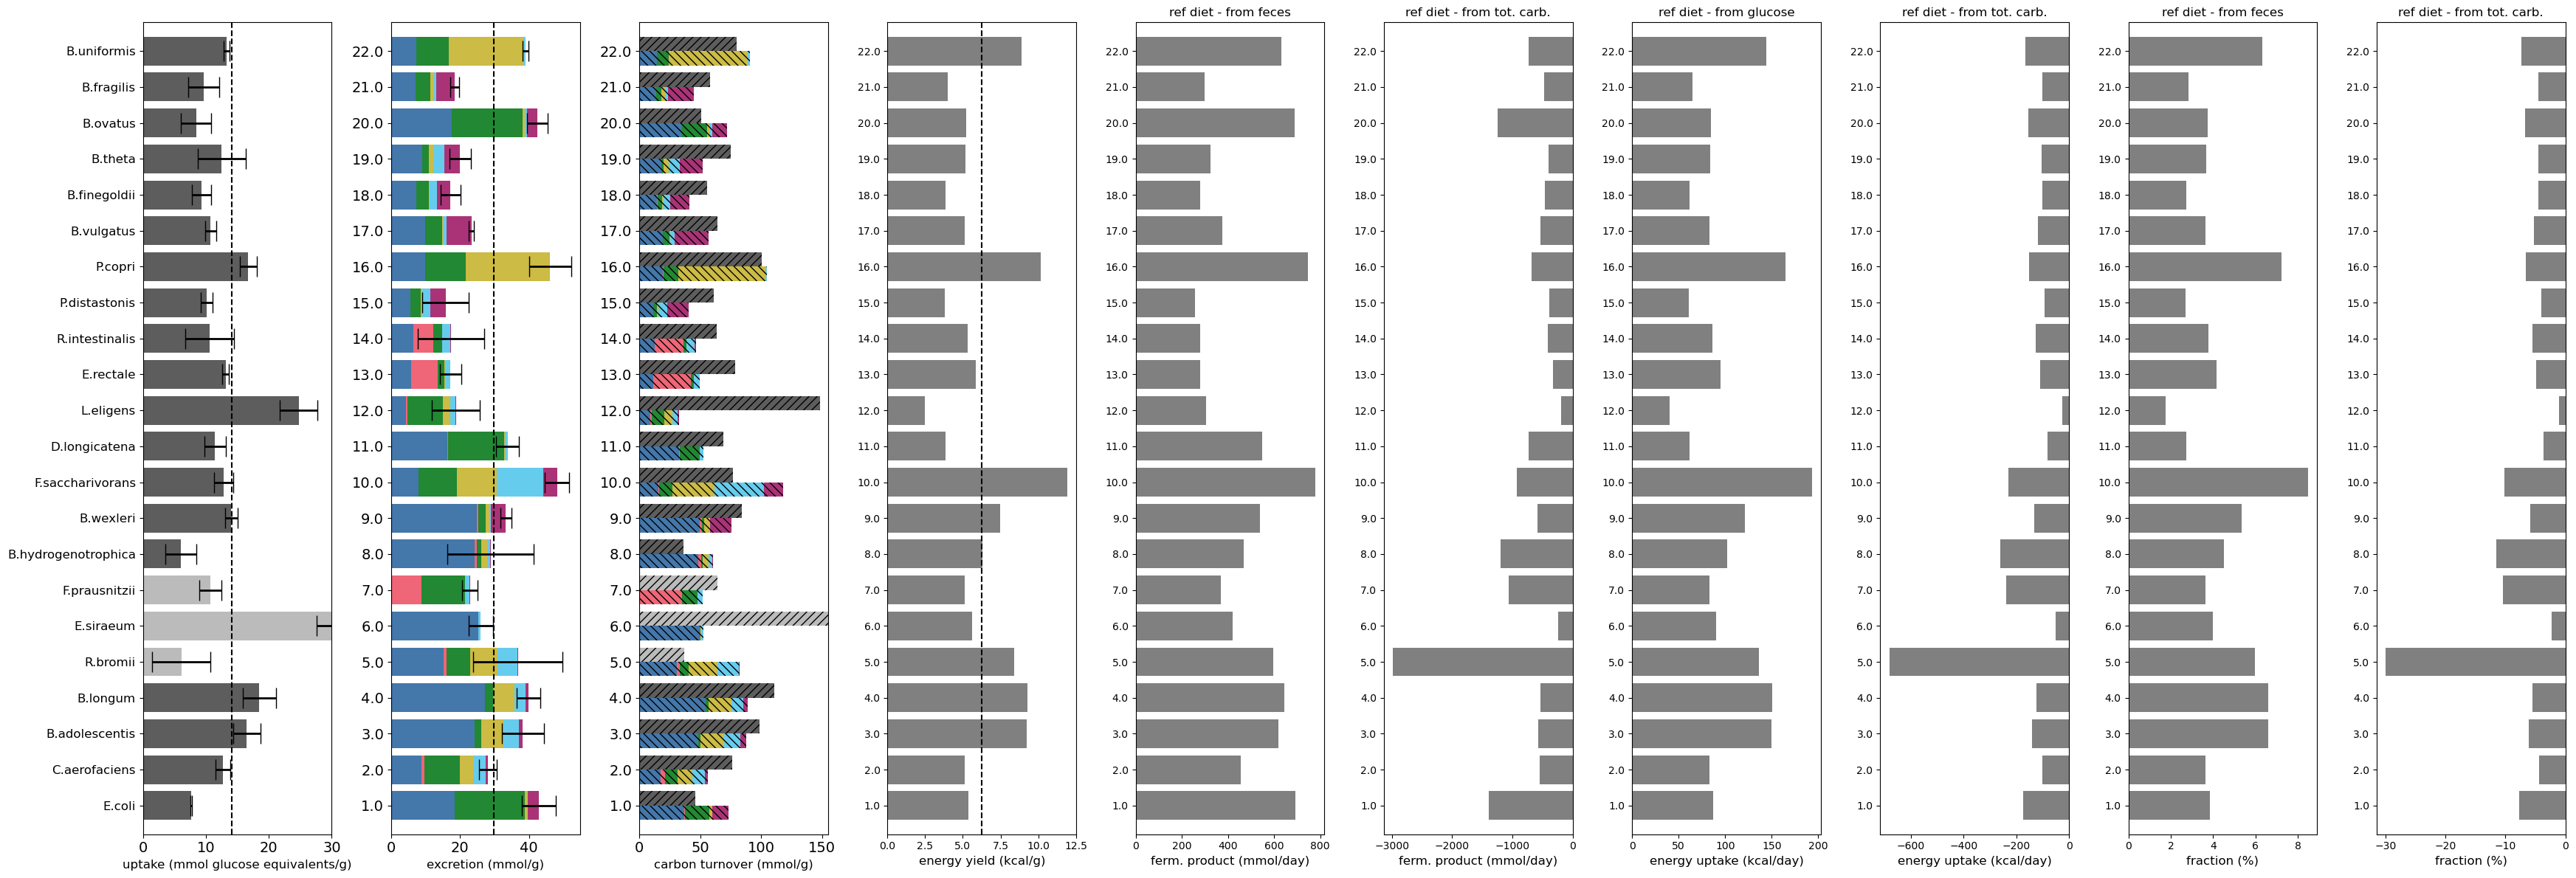

epsilon


Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  \
exp_number                                                                  
av_B.fragilis_ATCC25285_epsilon             170           NaN         NaN   
av_B.ovatus_ATCC8483_epsilon                177           NaN         NaN   
av_B.theta_ATCC29148_epsilon                181           NaN         NaN   
av_E.rectale_ATCC33656_epsilon              197           NaN         NaN   
av_F.prausnitzii_DSM17677_epsilon           201           NaN         NaN   
av_R.bromii_ATCC27255_epsilon               208           NaN         NaN   
av_B.longum_DSM20219_epsilon                174           NaN         NaN   
av_C.aerofaciens_DSM3979_epsilon            189           NaN         NaN   
av_E.coli_NCM3722_epsilon                   194           NaN         NaN   

                                   notes     strain        species  \
exp_number                                                           
av_B.fragilis_ATCC25285_epsilon      NaN  ATCC25285     B.fragilis   
av_B.ovatus_ATCC8483_epsilon         NaN   ATCC8483       B.ovatus   
av_B.theta_ATCC29148_epsilon         NaN  ATCC29148        B.theta   
av_E.rectale_ATCC33656_epsilon       NaN  ATCC33656      E.rectale   
av_F.prausnitzii_DSM17677_epsilon    NaN   DSM17677  F.prausnitzii   
av_R.bromii_ATCC27255_epsilon        NaN  ATCC27255       R.bromii   
av_B.longum_DSM20219_epsilon         NaN   DSM20219       B.longum   
av_C.aerofaciens_DSM3979_epsilon     NaN    DSM3979  C.aerofaciens   
av_E.coli_NCM3722_epsilon            NaN    NCM3722         E.coli   

                                                                          experiment  \
exp_number                                                                             
av_B.fragilis_ATCC25285_epsilon     av [174, 102, 151]_used_only: [14.0, 17.0, 20.0]   
av_B.ovatus_ATCC8483_epsilon                   av [175, 157]_used_only: [35.0, 39.0]   
av_B.theta_ATCC29148_epsilon       av [104, 62, 176, 153]_used_only: [44.0, 47.0,...   
av_E.rectale_ATCC33656_epsilon      av [82, 75, 68]_used_only: [123.0, 126.0, 138.0]   
av_F.prausnitzii_DSM17677_epsilon                        av [161]_used_only: [143.0]   
av_R.bromii_ATCC27255_epsilon                            av [164]_used_only: [196.0]   
av_B.longum_DSM20219_epsilon                              av [156]_used_only: [30.0]   
av_C.aerofaciens_DSM3979_epsilon               av [177, 105]_used_only: [97.0, 98.0]   
av_E.coli_NCM3722_epsilon                    av [162, 150]_used_only: [111.0, 113.0]   

                                  experiment_short   medium experimentator  \
exp_number                                                                   
av_B.fragilis_ATCC25285_epsilon                 av  epsilon            NaN   
av_B.ovatus_ATCC8483_epsilon                    av  epsilon            NaN   
av_B.theta_ATCC29148_epsilon                    av  epsilon            NaN   
av_E.rectale_ATCC33656_epsilon                  av  epsilon            NaN   
av_F.prausnitzii_DSM17677_epsilon               av  epsilon            NaN   
av_R.bromii_ATCC27255_epsilon                   av  epsilon            NaN   
av_B.longum_DSM20219_epsilon                    av  epsilon            NaN   
av_C.aerofaciens_DSM3979_epsilon                av  epsilon            NaN   
av_E.coli_NCM3722_epsilon                       av  epsilon            NaN   

                                   ...  succinate_std  lactate_std  \
exp_number                         ...                               
av_B.fragilis_ATCC25285_epsilon    ...       3.087290     0.135979   
av_B.ovatus_ATCC8483_epsilon       ...       0.591842     1.718142   
av_B.theta_ATCC29148_epsilon       ...       0.600831     0.709644   
av_E.rectale_ATCC33656_epsilon     ...       0.000000     0.697485   
av_F.prausnitzii_DSM17677_epsilon  ...            NaN          NaN   
av_R.bromii_ATCC27255_epsilon      ...            NaN          NaN   
av_B.longum_DSM20219_epsilon

9


/var/folders/4b/8dffvbfs5qs93rh77f2zxs340000gn/T/ipykernel_7281/3916249972.py:137: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.7.
  ax[2].barh(straincount-0.2,cfactor*datacur.at[index,sub]*conversionfactor,left=basec,color=color,label=label,height=0.4,hatch='\\\\\ ')
/Users/jonascremer/mambaforge/envs/jlab/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1098: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/Users/jonascremer/mambaforge/envs/jlab/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1099: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])


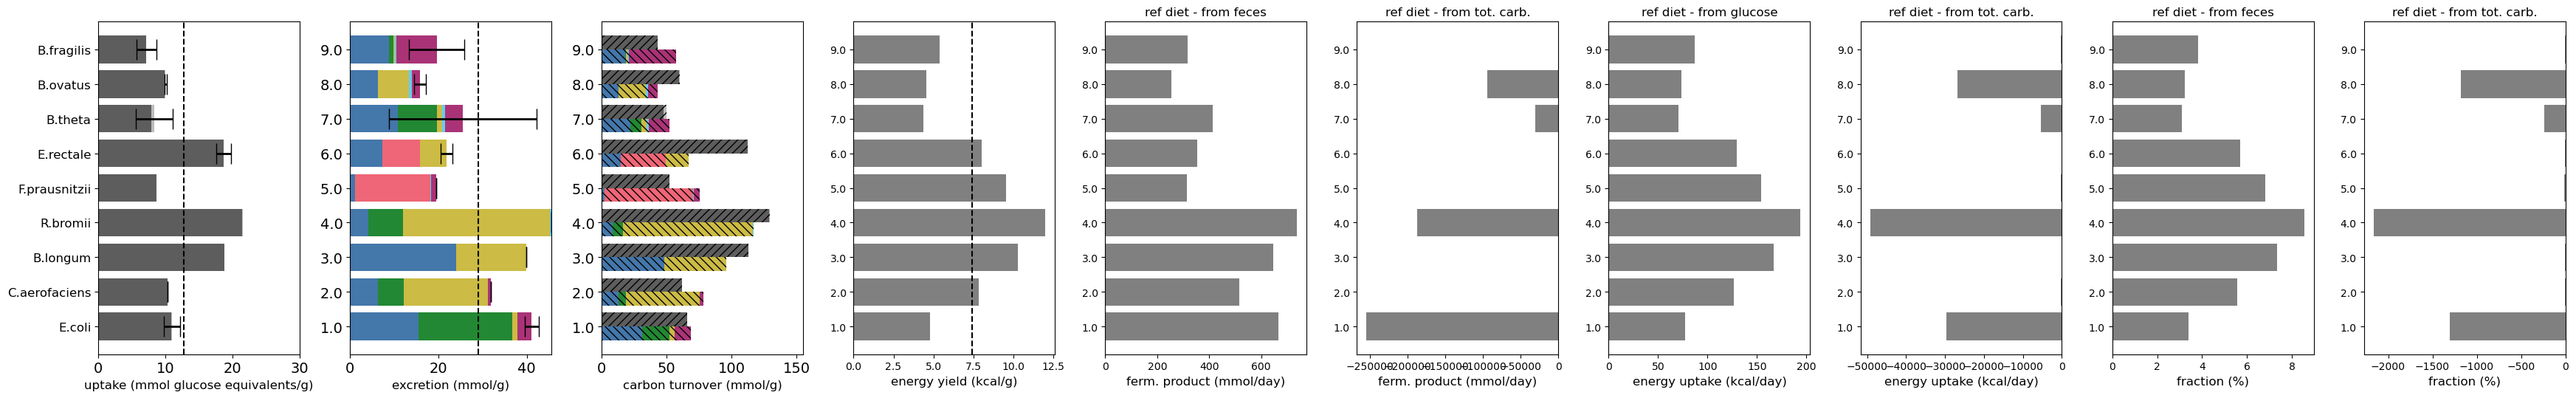

gamma


Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  notes  \
exp_number                                                                     
av_B.fragilis_ATCC25285_gamma           169           NaN         NaN    NaN   
av_B.theta_ATCC29148_gamma              180           NaN         NaN    NaN   
av_B.vulgatus_DSM 1447_gamma            185           NaN         NaN    NaN   
av_E.coli_NCM3722_gamma                 193           NaN         NaN    NaN   

                                  strain     species  \
exp_number                                             
av_B.fragilis_ATCC25285_gamma  ATCC25285  B.fragilis   
av_B.theta_ATCC29148_gamma     ATCC29148     B.theta   
av_B.vulgatus_DSM 1447_gamma    DSM 1447  B.vulgatus   
av_E.coli_NCM3722_gamma          NCM3722      E.coli   

                                                                      experiment  \
exp_number                                                                         
av_B.fragilis_ATCC25285_gamma              av [147, 113]_used_only: [13.0, 15.0]   
av_B.theta_ATCC29148_gamma      av [115, 202, 203]_used_only: [45.0, 48.0, 54.0]   
av_B.vulgatus_DSM 1447_gamma               av [205, 204]_used_only: [65.0, 70.0]   
av_E.coli_NCM3722_gamma        av [207, 206, 146, 112]_used_only: [104.0, 105...   

                              experiment_short medium experimentator  ...  \
exp_number                                                            ...   
av_B.fragilis_ATCC25285_gamma               av  gamma            NaN  ...   
av_B.theta_ATCC29148_gamma                  av  gamma            NaN  ...   
av_B.vulgatus_DSM 1447_gamma                av  gamma            NaN  ...   
av_E.coli_NCM3722_gamma                     av  gamma            NaN  ...   

                               succinate_std  lactate_std butyrate_std  \
exp_number                                                               
av_B.fragilis_ATCC25285_gamma       0.131018     0.299771          0.0   
av_B.theta_ATCC29148_gamma          0.172813     1.095500          0.0   
av_B.vulgatus_DSM 1447_gamma        0.240028     0.070391          0.0   
av_E.coli_NCM3722_gamma             0.141871     0.179215          0.0   

                              formate_std maltose_std  total_ferm  \
exp_number                                                          
av_B.fragilis_ATCC25285_gamma    2.215931    0.022941   11.018364   
av_B.theta_ATCC29148_gamma       0.900057    0.057140   21.628412   
av_B.vulgatus_DSM 1447_gamma     0.000000    0.000000    6.217655   
av_E.coli_NCM3722_gamma          1.740448    0.000000   36.982393   

                              total_ferm_std  total_uptake  total_uptake_std  \
exp_number                                                                     
av_B.fragilis_ATCC25285_gamma       2.910421     -6.358132          1.663738   
av_B.theta_ATCC29148_gamma          2.444916     -5.235678          0.787883   
av_B.vulgatus_DSM 1447_gamma        0.188644     -5.729968          0.262886   
av_E.coli_NCM3722_gamma             2.023836    -12.304877          1.118523   

                               growth_rate_std  
exp_number                                      
av_B.fragilis_ATCC25285_gamma         0.067995  
av_B.theta_ATCC29148_gamma            0.094339  
av_B.vulgatus_DSM 1447_gamma          0.053328  
av_E.coli_NCM3722_gamma               0.146521  

[4 rows x 64 columns]

/var/folders/4b/8dffvbfs5qs93rh77f2zxs340000gn/T/ipykernel_7281/3916249972.py:137: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.7.
  ax[2].barh(straincount-0.2,cfactor*datacur.at[index,sub]*conversionfactor,left=basec,color=color,label=label,height=0.4,hatch='\\\\\ ')


4


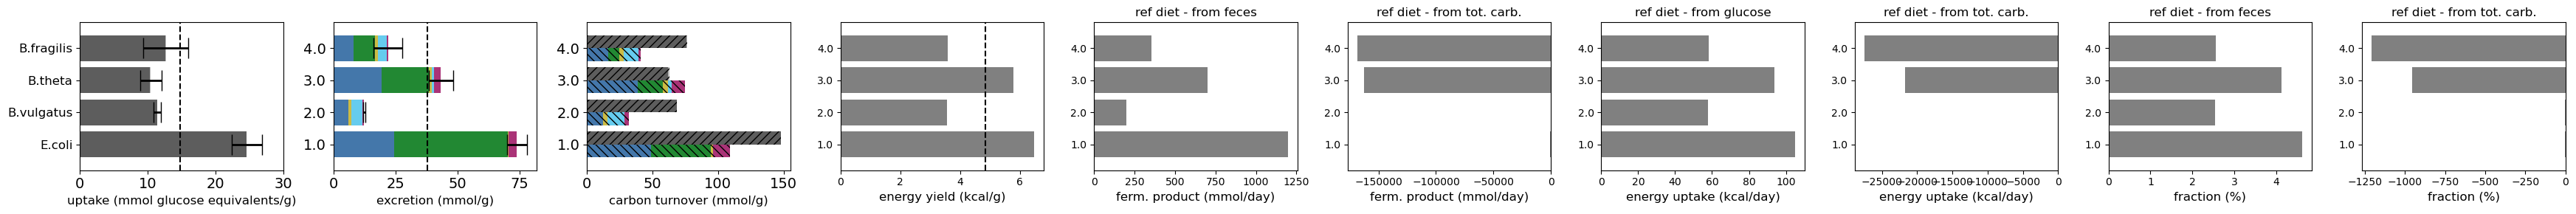

BHI


Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  notes  \
exp_number                                                                      
av_B.fragilis_ATCC25285_BHI              168           NaN         NaN    NaN   
av_B.ovatus_ATCC8483_BHI                 176           NaN         NaN    NaN   
av_B.theta_ATCC29148_BHI                 179           NaN         NaN    NaN   
av_B.finegoldii_HM-727_BHI               166           NaN         NaN    NaN   
av_B.vulgatus_DSM 1447_BHI               184           NaN         NaN    NaN   
av_P.distastonis_HM-169_BHI              206           NaN         NaN    NaN   
av_R.intestinalis_DSM14610_BHI           210           NaN         NaN    NaN   
av_E.rectale_ATCC33656_BHI               196           NaN         NaN    NaN   
av_F.prausnitzii_DSM17677_BHI            200           NaN         NaN    NaN   
av_B.longum_DSM20219_BHI                 173           NaN         NaN    NaN   
av_B.adolescentis_DSM20083_BHI           164           NaN         NaN    NaN   
av_C.aerofaciens_DSM3979_BHI             188           NaN         NaN    NaN   
av_E.coli_NCM3722_BHI                    192           NaN         NaN    NaN   

                                   strain         species  \
exp_number                                                  
av_B.fragilis_ATCC25285_BHI     ATCC25285      B.fragilis   
av_B.ovatus_ATCC8483_BHI         ATCC8483        B.ovatus   
av_B.theta_ATCC29148_BHI        ATCC29148         B.theta   
av_B.finegoldii_HM-727_BHI         HM-727    B.finegoldii   
av_B.vulgatus_DSM 1447_BHI       DSM 1447      B.vulgatus   
av_P.distastonis_HM-169_BHI        HM-169   P.distastonis   
av_R.intestinalis_DSM14610_BHI   DSM14610  R.intestinalis   
av_E.rectale_ATCC33656_BHI      ATCC33656       E.rectale   
av_F.prausnitzii_DSM17677_BHI    DSM17677   F.prausnitzii   
av_B.longum_DSM20219_BHI         DSM20219        B.longum   
av_B.adolescentis_DSM20083_BHI   DSM20083  B.adolescentis   
av_C.aerofaciens_DSM3979_BHI      DSM3979   C.aerofaciens   
av_E.coli_NCM3722_BHI             NCM3722          E.coli   

                                                                       experiment  \
exp_number                                                                          
av_B.fragilis_ATCC25285_BHI                 av [194, 195]_used_only: [12.0, 16.0]   
av_B.ovatus_ATCC8483_BHI         av [190, 191, 168]_used_only: [33.0, 34.0, 40.0]   
av_B.theta_ATCC29148_BHI         av [189, 188, 169]_used_only: [49.0, 50.0, 56.0]   
av_B.finegoldii_HM-727_BHI         av [166, 116, 117]_used_only: [6.0, 9.0, 10.0]   
av_B.vulgatus_DSM 1447_BHI      av [118, 170, 200, 201, 119]_used_only: [62.0,...   
av_P.distastonis_HM-169_BHI     av [173, 123, 122, 172]_used_only: [187.0, 192...   
av_R.intestinalis_DSM14610_BHI  av [111, 110, 143]_used_only: [209.0, 210.0, 2...   
av_E.rectale_ATCC33656_BHI      av [108, 197, 196, 109, 137, 138]_used_only: [...   
av_F.prausnitzii_DSM17677_BHI   av [120, 139, 141, 121]_used_only: [157.0, 159...   
av_B.longum_DSM20219_BHI                    av [192, 193]_used_only: [31.0, 32.0]   
av_B.adolescentis_DSM20083_BHI                av [199, 198]_used_only: [4.0, 5.0]   
av_C.aerofaciens_DSM3979_BHI                av [142, 140]_used_only: [92.0, 99.0]   
av_E.coli_NCM3722_BHI           av [186, 187, 171]_used_only: [106.0, 107.0, 1...   

                               experiment_short medium experimentator  ...  \
exp_number                                                             ...   
av_B.fragilis_ATCC25285_BHI                  av    BHI            NaN  ...   
av_B.ovatus_ATCC8483_BHI                     av    BHI            NaN  ...   
av_B.theta_ATCC29148_BHI                     av    BHI            NaN  ...   
av_B.finegoldii_HM-727_BHI                   av    BHI            NaN  ...   
av_B.vulgatus_DSM 1447_BHI                   av    BHI            NaN  ...   
av_P.distastonis_HM-169_BHI                  av    BHI            NaN  ...   


13


/var/folders/4b/8dffvbfs5qs93rh77f2zxs340000gn/T/ipykernel_7281/3916249972.py:137: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.7.
  ax[2].barh(straincount-0.2,cfactor*datacur.at[index,sub]*conversionfactor,left=basec,color=color,label=label,height=0.4,hatch='\\\\\ ')


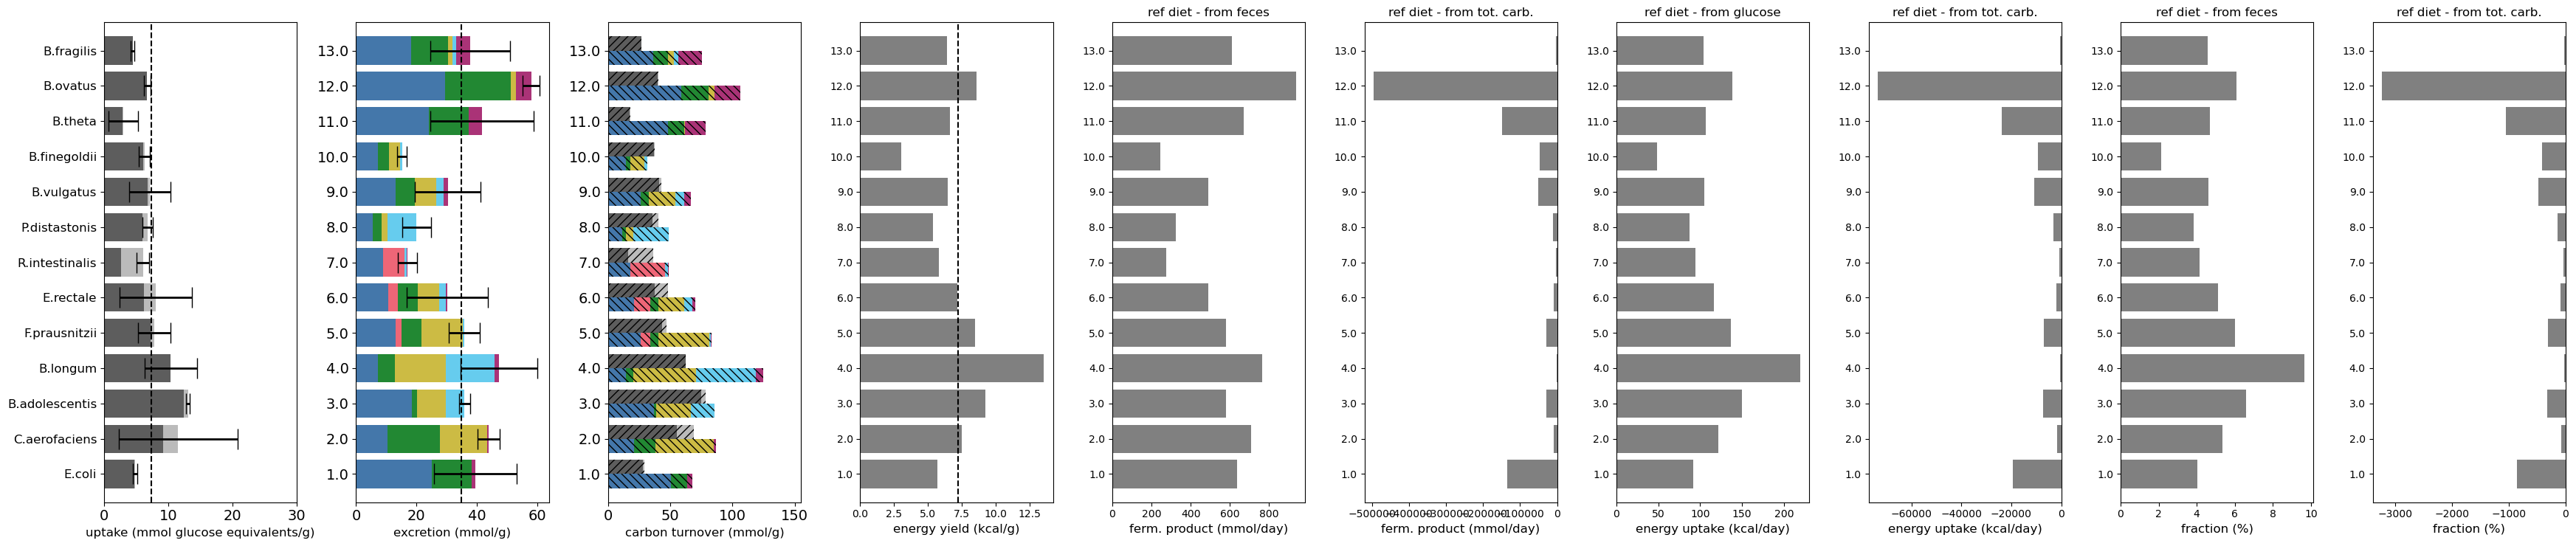

In [29]:
display(dataout_av.head())
add_mean=False

#abundance to calculate average rates
abundance_different_strains=[15.5,3,1.9,1.9,0.4,9.2,6.8,2.2,2.1,2.1,9,0.8,0.4,0.2,0.2,1.6][::-1]
abundance_different_strains=np.array(abundance_different_strains)/(sum(abundance_different_strains))


# different media['BHI' 'YCA' 'epsilon plus' 'simple' 'epsilon' 'fecal']
conversionfactor=1/(0.5) #multiply by OD ml/0.5mg to change unti from mM to:   ml mM / mg which is l mM / g which is mmol/g
for cond in [5,1,3,4]: #5,3,1,4
    
    if cond==1: #plot average values for different strains
        condname="epsilon"
        exp_numberlist=samplenamelist[media.index("epsilon")][::-1]
    #elif cond==2:
    #    condname="fecal"
    #    exp_numberlist=samplenamelist[media.index("fecal")][::-1]
    elif cond==3:
        condname="gamma"
        exp_numberlist=samplenamelist[media.index("gamma")][::-1]
    elif cond==4:
        condname="BHI"
        exp_numberlist=samplenamelist[media.index("BHI")][::-1]
    elif cond==5:
        condname="YCA"
        exp_numberlist=samplenamelist[media.index("YCA")][::-1]
    
    print(condname)
    
    
    datacur=dataout_av.loc[dataout_av["exp_number"].isin(exp_numberlist)]
    datacur=datacur.set_index("exp_number")
    display(datacur)

    
    numexp=datacur.shape[0]
    fig, ax = plt.subplots(1,10,figsize=(35,1+0.5*numexp))  
    ax[0].set_xlabel("uptake (mmol glucose equivalents/g)",fontsize=fontsize)
    ax[1].set_xlabel("excretion (mmol/g)",fontsize=fontsize)
    ax[2].set_xlabel("carbon turnover (mmol/g)",fontsize=fontsize)
    ax[3].set_xlabel("energy yield (kcal/g)",fontsize=fontsize)
    ax[4].set_xlabel("ferm. product (mmol/day)",fontsize=fontsize)
    ax[5].set_xlabel("ferm. product (mmol/day)",fontsize=fontsize)
    ax[6].set_xlabel("energy uptake (kcal/day)",fontsize=fontsize)
    ax[7].set_xlabel("energy uptake (kcal/day)",fontsize=fontsize)
    ax[8].set_xlabel("fraction (%)",fontsize=fontsize)
    ax[9].set_xlabel("fraction (%)",fontsize=fontsize)

    
    for cc in range(0,10):
        ax[cc].set_yticks([-1.5,-0.5]+list(range(1,numexp+1)))
        if add_mean:
            ax[cc].set_ylim(-2,numexp+1)
            if cond==1:
                ax[cc].set_ylim(-3,numexp+3)
        else:
            ax[cc].set_ylim(0.2,numexp+1-0.2)
        straincount=0
    strainl=[]
    strainllabelbar=[]

    consumptionl=[]
    excretionl=[]
    energycontentl=[]
    
                    
    excretion_singlel=np.zeros([len(exp_numberlist),8])
    strainlist2=[]
    iS = -1

    mean_ut=[]
    mean_excretion=[]
    mean_ut_c=[]
    mean_excretion_c=[]
    
    for index in exp_numberlist:
                iS = iS+1
                straincount=straincount+1
                ic = -1
                base=0
                basec=0
                baseut=0
                basecut=0
                energy=0
                
                strainl.append(datacur.at[index,"strain"])
                strainlist2.append(datacur.at[index,"strain"])
                strainllabelbar.append(datacur.at[index,"species"])#+" "+datacur.at[index,"strain"])
                mean_excretion_singlestrain=0
                mean_excretion_singlestrain_c=0
                mean_uptake_singlestrain=0
                mean_uptake_singlestrain_c=0
                consumpc=0
                for sub in sublist:
                    ic=ic+1
                    cfactor=cfactorlist[ic]
                    color=colorlist[ic]
                    if straincount==1:
                        label=sublistshort[ic]
                    else:
                        label=None
                    
                    if sub in ["glucose"]:# and (strainl[-1] not in ["DSM17677","ATCC27255"]):
                        ax[0].barh(straincount,-1*datacur.at[index,sub]*conversionfactor,left=baseut,color=color,label=label,height=0.8)
                        ax[2].barh(straincount+0.2,-1*cfactor*datacur.at[index,sub]*conversionfactor,left=basecut,label=label,color=color,height=0.4,hatch='///')
                        
                        consumpc=consumpc-1*datacur.at[index,sub]*conversionfactor
                        
                        if datacur.at[index,sub]<0:
                            basecut=basec-cfactor*datacur.at[index,sub]*conversionfactor
                            baseut=base-datacur.at[index,sub]*conversionfactor
                        mean_uptake_singlestrain=mean_uptake_singlestrain-conversionfactor*datacur.at[index,sub]
                        mean_uptake_singlestrain_c=mean_uptake_singlestrain_c-cfactor*conversionfactor*datacur.at[index,sub]
               
                        inverseyield=-1*baseut*0.18 #mmol/g bacteria *0.18 g glucose /mmol -> gram glucose/gram bacter
                        excretion_singlel[iS,ic] = -1*datacur.at[index,sub]*conversionfactor
                    
                    elif sub in ["maltose"]: #and (strainl[-1]  in ["DSM17677","ATCC27255"]):
                        ax[0].barh(straincount,-2*datacur.at[index,sub]*conversionfactor,left=baseut,color=color,label=label,height=0.8)
                        ax[2].barh(straincount+0.2,-1*cfactor*datacur.at[index,sub]*conversionfactor,left=basecut,label=label,color=color,height=0.4,hatch='///')
                        consumpc=consumpc-2*datacur.at[index,sub]*conversionfactor
                        mean_uptake_singlestrain=mean_uptake_singlestrain-conversionfactor*datacur.at[index,sub]
                        mean_uptake_singlestrain_c=mean_uptake_singlestrain_c-cfactor*conversionfactor*datacur.at[index,sub]
               
                        
                        if datacur.at[index,sub]<0:
                            basecut=basec-cfactor*datacur.at[index,sub]*conversionfactor
                            baseut=base-datacur.at[index,sub]*conversionfactor
                        
                        inverseyield=-1*baseut*0.18 #mmol/g bacteria *0.18 g glucose /mmol -> gram glucose/gram bacter
                        excretion_singlel[iS,ic] = -1*datacur.at[index,sub]*conversionfactor
                    
                    
                    else:# datacur.at[index,sub]>0.5: #for other fermentation products, require more than 0.5
                        ax[1].barh(straincount,datacur.at[index,sub]*conversionfactor,left=base,color=color,label=label,height=0.8)
                        ax[2].barh(straincount-0.2,cfactor*datacur.at[index,sub]*conversionfactor,left=basec,color=color,label=label,height=0.4,hatch='\\\\\ ')
                        
                        basec=basec+cfactor*datacur.at[index,sub]*conversionfactor
                        base=base+datacur.at[index,sub]*conversionfactor
                        energy=energy+datacur.at[index,sub]*conversionfactor*energycontent[ic] #unit mmol/g *energycontent (unit kcal/mmol)
                        excretion_singlel[iS,ic] = datacur.at[index,sub]*conversionfactor
                        if datacur.at[index,sub]>0:
                            mean_excretion_singlestrain=mean_excretion_singlestrain+datacur.at[index,sub]*conversionfactor
                            mean_excretion_singlestrain_c=mean_excretion_singlestrain_c+datacur.at[index,sub]*conversionfactor*cfactor
                consumptionl.append(consumpc)
                ax[0].errorbar(conversionfactor*datacur.at[index,"total_uptake"]*(-1),straincount,xerr=conversionfactor*datacur.at[index,"total_uptake_std"],color='k',capsize=10, elinewidth=2)
                ax[1].errorbar(conversionfactor*datacur.at[index,"total_ferm"],straincount,xerr=conversionfactor*datacur.at[index,"total_ferm_std"],color='k', capsize=10, elinewidth=2)
                mean_excretion.append(mean_excretion_singlestrain) 
                mean_excretion_c.append(mean_excretion_singlestrain_c)    
                mean_ut.append(mean_uptake_singlestrain)
                mean_ut_c.append(mean_uptake_singlestrain_c)
                       
                excretionl.append(base)
                energycontentl.append(energy)
                #energy content
                ax[3].barh(straincount,energy,left=0,color='gray',label=label,height=0.8)
                
                #bacterial drymass
                bactmass_ref=16.18 #for British ref diet g/day
                carbin_ref=44.6 #fro British ref diet g/day
                ax[4].set_title("ref diet - from feces")
                ax[4].barh(straincount,base*bactmass_ref,left=0,color='gray',label=label,height=0.8) #mmol/day
                ax[5].set_title("ref diet - from tot. carb.")
                ax[5].barh(straincount,base*carbin_ref/inverseyield,left=0,color='gray',label=label,height=0.8) #mmol/day
                
                ax[6].set_title("ref diet - from glucose")
                ax[6].barh(straincount,energy*bactmass_ref,left=0,color='gray',label=label,height=0.8) #mmol/day
                ax[7].set_title("ref diet - from tot. carb.")
                ax[7].barh(straincount,energy*carbin_ref/inverseyield,left=0,color='gray',label=label,height=0.8) #mmol/day
                
                totalcen_ref=2275.0 #kcal/day for british ref diet
                ax[8].set_title("ref diet - from feces")
                ax[8].barh(straincount,100*energy*bactmass_ref/totalcen_ref,left=0,color='gray',label=label,height=0.8) #mmol/day
                ax[9].set_title("ref diet - from tot. carb.")
                ax[9].barh(straincount,100*energy*carbin_ref/inverseyield/totalcen_ref,left=0,color='gray',label=label,height=0.8) #mmol/day
                
                           
                
    if add_mean:
        print(mean_excretion)
        print(mean_excretion_c)
        ax[0].barh(-0.5,np.average(mean_ut),left=0,color='dimgray',label=label,height=0.8) #mmol/day
        ax[1].barh(-0.5,np.average(mean_excretion),left=0,color='silver',label=label,height=0.8) #mmol/day
        ax[2].barh(-0.5+0.2,np.average(mean_ut_c),left=0,label="mean",color='dimgray',height=0.4,hatch='///')
        ax[2].barh(-0.5-0.2,np.average(mean_excretion_c),left=0,label="mean",color='silver',height=0.4,hatch='\\\\\ ')
    
        abundance_different_strains=np.array(abundance_different_strains)
        mean_ut=np.array(mean_ut)
        mean_excretion=np.array(mean_excretion)
        mean_ut_c=np.array(mean_ut_c)
        mean_excretion_c=np.array(mean_excretion_c)
        
        ax[0].barh(-1.5,np.sum(np.multiply(abundance_different_strains,mean_ut)),left=0,color='dimgray',label=label,height=0.8) #mmol/day
        ax[1].barh(-1.5,np.sum(np.multiply(abundance_different_strains,mean_excretion)),left=0,color='silver',label=label,height=0.8) #mmol/day
        ax[2].barh(-1.5+0.2,np.sum(np.multiply(abundance_different_strains,mean_ut_c)),left=0,label="mean",color='dimgray',height=0.4,hatch='///')
        ax[2].barh(-1.5-0.2,np.sum(np.multiply(abundance_different_strains,mean_excretion_c)),left=0,label="mean",color='silver',height=0.4,hatch='\\\\\ ')
        
        print("average secretion")
        print(np.sum(np.multiply(abundance_different_strains,mean_excretion)))
        
    excretion_singlel=pd.DataFrame(excretion_singlel,columns=sublist).iloc[::-1]
    excretion_singlel.index=strainlist2[::-1]
    
    excretionl=np.array(excretionl[::-1])
    consumptionl=np.array(consumptionl[::-1])
    energycontentl=np.array(energycontentl[::-1])
    
    if 2>4: #cond==1:
        #add reference condition
        base2=0
        basec2=0
        base2ut=0
        basec2ut=0
        energy2=0
        ic = -1
        for sub in sublist:
            ic = ic+1
            cfactor=cfactorlist[ic]
            color=colorlist[ic]
            
            if sub in ['glucose','maltose']:
                ax[0].barh(straincount+1,ref_values[sub],left=base2ut,color='k',height=0.8)
                ax[2].barh(straincount+1-0.2,cfactor*ref_values[sub],left=basec2ut,label=label,color=color,height=0.4,hatch='///')
                basec2ut=basec2ut+cfactor*ref_values[sub]
                base2ut=base2ut+ref_values[sub]
               
            else:
                ax[1].barh(straincount+1,ref_values[sub],left=base2,color=color,label=label,height=0.8)
                ax[2].barh(straincount+1+0.2,cfactor*ref_values[sub],left=basec2,label=label,color=color,height=0.4,hatch='\\\\\ ')
                
                basec2=basec2+cfactor*ref_values[sub]
                base2=base2+ref_values[sub]
                energy2=energy2+ref_values[sub]*energycontent[ic] #unit mmol/g *energycontent (unit kcal/mmol)
        ax[3].barh(straincount+1,energy2,left=0,color='k',label=label,height=0.8)
        
        ax[4].barh(straincount+1,base2*bactmass_ref,left=0,color='k',label=label,height=0.8) #mmol/day
        ax[5].barh(straincount+1,base2*carbin_ref/inverseyield,left=0,color='k',label=label,height=0.8) #mmol/day
                
        ax[6].barh(straincount+1,energy2*bactmass_ref,left=0,color='k',label=label,height=0.8) #mmol/day
        ax[7].barh(straincount+1,energy2*carbin_ref/inverseyield,left=0,color='k',label=label,height=0.8) #mmol/day
                
        ax[8].barh(straincount+1,100*energy2*bactmass_ref/totalcen_ref,left=0,color='k',label=label,height=0.8) #mmol/day
        ax[9].barh(straincount+1,100*energy2*carbin_ref/inverseyield/totalcen_ref,left=0,color='k',label=label,height=0.8) #mmol/day
    
    #uptake set range
    ax[0].set_xlim(0,30)
    #ax[1].set_xlim(0,120)
    #carbon turnover set range
    ax[2].set_xlim(0,155)
    
    
    ax[0].axvline(consumptionl[:].mean(),ls='--',color='k')
    
    ax[1].axvline(excretionl[:].mean(),ls='--',color='k')
          
    ax[3].axvline(energycontentl[:].mean(),ls='--',color='k')
    ax[0].tick_params(axis='both', which='major', labelsize=14)
    ax[1].tick_params(axis='both', which='major', labelsize=14)
    ax[2].tick_params(axis='both', which='major', labelsize=14)
    print(len(strainllabelbar))
    ax[0].set_yticklabels(["weighted by\n abundance","average"]+strainllabelbar,fontsize=fontsize)
    plt.tight_layout()
    fig.savefig("plot_output_figure1/barplots_"+condname+".pdf")
    plt.show()

# Fermentation products - scattering

YCA


Unnamed: 0.2  Unnamed: 0.1  \
exp_number                                                                   
av_B.uniformis_ATCC8492_YCA                              182           NaN   
av_B.fragilis_ATCC25285_YCA                              167           NaN   
av_B.ovatus_ATCC8483_YCA                                 175           NaN   
av_B.theta_ATCC29148_YCA                                 178           NaN   
av_B.finegoldii_HM-727_YCA                               165           NaN   
av_B.vulgatus_DSM 1447_YCA                               183           NaN   
av_P.copri_DSM18205_YCA                                  204           NaN   
av_P.distastonis_HM-169_YCA                              205           NaN   
av_R.intestinalis_DSM14610_YCA                           209           NaN   
av_E.rectale_ATCC33656_YCA                               195           NaN   
av_L.eligens_L.eligens_YCA                               203           NaN   
av_D.longicatena_D.longicatena_YCA                       190           NaN   
av_F.saccharivorans_F.saccharivorans_YCA                 202           NaN   
av_B.wexleri_B.wexleri_YCA                               186           NaN   
av_B.hydrogenotrophica_B.hydrogenotrophica_YCA           171           NaN   
av_F.prausnitzii_DSM17677_YCA                            199           NaN   
av_E.siraeum_DSM15702_YCA                                198           NaN   
av_R.bromii_ATCC27255_YCA                                207           NaN   
av_B.longum_DSM20219_YCA                                 172           NaN   
av_B.adolescentis_DSM20083_YCA                           163           NaN   
av_C.aerofaciens_DSM3979_YCA                             187           NaN   
av_E.coli_NCM3722_YCA                                    191           NaN   

                                                Unnamed: 0  notes  \
exp_number                                                          
av_B.uniformis_ATCC8492_YCA                            NaN    NaN   
av_B.fragilis_ATCC25285_YCA                            NaN    NaN   
av_B.ovatus_ATCC8483_YCA                               NaN    NaN   
av_B.theta_ATCC29148_YCA                               NaN    NaN   
av_B.finegoldii_HM-727_YCA                             NaN    NaN   
av_B.vulgatus_DSM 1447_YCA                             NaN    NaN   
av_P.copri_DSM18205_YCA                                NaN    NaN   
av_P.distastonis_HM-169_YCA                            NaN    NaN   
av_R.intestinalis_DSM14610_YCA                         NaN    NaN   
av_E.rectale_ATCC33656_YCA                             NaN    NaN   
av_L.eligens_L.eligens_YCA                             NaN    NaN   
av_D.longicatena_D.longicatena_YCA                     NaN    NaN   
av_F.saccharivorans_F.saccharivorans_YCA               NaN    NaN   
av_B.wexleri_B.wexleri_YCA                             NaN    NaN   
av_B.hydrogenotrophica_B.hydrogenotrophica_YCA         NaN    NaN   
av_F.prausnitzii_DSM17677_YCA                          NaN    NaN   
av_E.siraeum_DSM15702_YCA                              NaN    NaN   
av_R.bromii_ATCC27255_YCA                              NaN    NaN   
av_B.longum_DSM20219_YCA                               NaN    NaN   
av_B.adolescentis_DSM20083_YCA                         NaN    NaN   
av_C.aerofaciens_DSM3979_YCA                           NaN    NaN   
av_E.coli_NCM3722_YCA                                  NaN    NaN   

                                                             strain  \
exp_number                                                            
av_B.uniformis_ATCC8492_YCA                                ATCC8492   
av_B.fragilis_ATCC25285_YCA                               ATCC25285   
av_B.ovatus_ATCC8483_YCA                                   ATCC8483   
av_B.theta_ATCC29148_YCA                                  ATCC29148   
av_B.finegoldii_HM-727_YCA                                   HM-727   
av_B.vulgatus_DSM 144

condition
1
[ 7.62959395 12.69996248 16.47776977 18.48606135  6.10548668 54.68426911
 10.68339532  6.00229494 14.03159422 12.8343778  11.45830379 24.76403795
 13.14521778 10.54330096 10.16179512 16.73337614 10.7301594   9.30944244
 12.49699941  8.42170184  9.66447461 13.30140203]
[42.86125545 28.05709668 38.22597387 39.90582408 36.78388631 26.03425662
 22.85387724 28.85245073 33.33591691 48.15626222 33.81177632 18.85722184
 17.2542329  17.36649056 15.8119049  46.12514097 23.27362781 17.25983469
 20.01871408 42.48781088 18.44170514 39.04497864]
BHI


Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  notes  \
exp_number                                                                      
av_B.fragilis_ATCC25285_BHI              168           NaN         NaN    NaN   
av_B.ovatus_ATCC8483_BHI                 176           NaN         NaN    NaN   
av_B.theta_ATCC29148_BHI                 179           NaN         NaN    NaN   
av_B.finegoldii_HM-727_BHI               166           NaN         NaN    NaN   
av_B.vulgatus_DSM 1447_BHI               184           NaN         NaN    NaN   
av_P.distastonis_HM-169_BHI              206           NaN         NaN    NaN   
av_R.intestinalis_DSM14610_BHI           210           NaN         NaN    NaN   
av_E.rectale_ATCC33656_BHI               196           NaN         NaN    NaN   
av_F.prausnitzii_DSM17677_BHI            200           NaN         NaN    NaN   
av_B.longum_DSM20219_BHI                 173           NaN         NaN    NaN   
av_B.adolescentis_DSM20083_BHI           164           NaN         NaN    NaN   
av_C.aerofaciens_DSM3979_BHI             188           NaN         NaN    NaN   
av_E.coli_NCM3722_BHI                    192           NaN         NaN    NaN   

                                   strain         species  \
exp_number                                                  
av_B.fragilis_ATCC25285_BHI     ATCC25285      B.fragilis   
av_B.ovatus_ATCC8483_BHI         ATCC8483        B.ovatus   
av_B.theta_ATCC29148_BHI        ATCC29148         B.theta   
av_B.finegoldii_HM-727_BHI         HM-727    B.finegoldii   
av_B.vulgatus_DSM 1447_BHI       DSM 1447      B.vulgatus   
av_P.distastonis_HM-169_BHI        HM-169   P.distastonis   
av_R.intestinalis_DSM14610_BHI   DSM14610  R.intestinalis   
av_E.rectale_ATCC33656_BHI      ATCC33656       E.rectale   
av_F.prausnitzii_DSM17677_BHI    DSM17677   F.prausnitzii   
av_B.longum_DSM20219_BHI         DSM20219        B.longum   
av_B.adolescentis_DSM20083_BHI   DSM20083  B.adolescentis   
av_C.aerofaciens_DSM3979_BHI      DSM3979   C.aerofaciens   
av_E.coli_NCM3722_BHI             NCM3722          E.coli   

                                                                       experiment  \
exp_number                                                                          
av_B.fragilis_ATCC25285_BHI                 av [194, 195]_used_only: [12.0, 16.0]   
av_B.ovatus_ATCC8483_BHI         av [190, 191, 168]_used_only: [33.0, 34.0, 40.0]   
av_B.theta_ATCC29148_BHI         av [189, 188, 169]_used_only: [49.0, 50.0, 56.0]   
av_B.finegoldii_HM-727_BHI         av [166, 116, 117]_used_only: [6.0, 9.0, 10.0]   
av_B.vulgatus_DSM 1447_BHI      av [118, 170, 200, 201, 119]_used_only: [62.0,...   
av_P.distastonis_HM-169_BHI     av [173, 123, 122, 172]_used_only: [187.0, 192...   
av_R.intestinalis_DSM14610_BHI  av [111, 110, 143]_used_only: [209.0, 210.0, 2...   
av_E.rectale_ATCC33656_BHI      av [108, 197, 196, 109, 137, 138]_used_only: [...   
av_F.prausnitzii_DSM17677_BHI   av [120, 139, 141, 121]_used_only: [157.0, 159...   
av_B.longum_DSM20219_BHI                    av [192, 193]_used_only: [31.0, 32.0]   
av_B.adolescentis_DSM20083_BHI                av [199, 198]_used_only: [4.0, 5.0]   
av_C.aerofaciens_DSM3979_BHI                av [142, 140]_used_only: [92.0, 99.0]   
av_E.coli_NCM3722_BHI           av [186, 187, 171]_used_only: [106.0, 107.0, 1...   

                               experiment_short medium experimentator  ...  \
exp_number                                                             ...   
av_B.fragilis_ATCC25285_BHI                  av    BHI            NaN  ...   
av_B.ovatus_ATCC8483_BHI                     av    BHI            NaN  ...   
av_B.theta_ATCC29148_BHI                     av    BHI            NaN  ...   
av_B.finegoldii_HM-727_BHI                   av    BHI            NaN  ...   
av_B.vulgatus_DSM 1447_BHI                   av    BHI            NaN  ...   
av_P.distastonis_HM-169_BHI                  av    BHI            NaN  ...   


condition
2
[ 4.81314173 11.52546623 13.05859986 10.40340843  7.82373663  8.04033857
  6.0657808   6.76271405  7.10242559  6.27784834  2.96802364  6.71136708
  4.45711872]
[39.3183211  43.77380532 35.82263853 47.2428911  35.81737642 30.15975448
 16.90024447 20.00410683 30.25383946 15.24082023 41.53434093 57.87527658
 37.70079627]
epsilon


Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  \
exp_number                                                                  
av_B.fragilis_ATCC25285_epsilon             170           NaN         NaN   
av_B.ovatus_ATCC8483_epsilon                177           NaN         NaN   
av_B.theta_ATCC29148_epsilon                181           NaN         NaN   
av_E.rectale_ATCC33656_epsilon              197           NaN         NaN   
av_F.prausnitzii_DSM17677_epsilon           201           NaN         NaN   
av_R.bromii_ATCC27255_epsilon               208           NaN         NaN   
av_B.longum_DSM20219_epsilon                174           NaN         NaN   
av_C.aerofaciens_DSM3979_epsilon            189           NaN         NaN   
av_E.coli_NCM3722_epsilon                   194           NaN         NaN   

                                   notes     strain        species  \
exp_number                                                           
av_B.fragilis_ATCC25285_epsilon      NaN  ATCC25285     B.fragilis   
av_B.ovatus_ATCC8483_epsilon         NaN   ATCC8483       B.ovatus   
av_B.theta_ATCC29148_epsilon         NaN  ATCC29148        B.theta   
av_E.rectale_ATCC33656_epsilon       NaN  ATCC33656      E.rectale   
av_F.prausnitzii_DSM17677_epsilon    NaN   DSM17677  F.prausnitzii   
av_R.bromii_ATCC27255_epsilon        NaN  ATCC27255       R.bromii   
av_B.longum_DSM20219_epsilon         NaN   DSM20219       B.longum   
av_C.aerofaciens_DSM3979_epsilon     NaN    DSM3979  C.aerofaciens   
av_E.coli_NCM3722_epsilon            NaN    NCM3722         E.coli   

                                                                          experiment  \
exp_number                                                                             
av_B.fragilis_ATCC25285_epsilon     av [174, 102, 151]_used_only: [14.0, 17.0, 20.0]   
av_B.ovatus_ATCC8483_epsilon                   av [175, 157]_used_only: [35.0, 39.0]   
av_B.theta_ATCC29148_epsilon       av [104, 62, 176, 153]_used_only: [44.0, 47.0,...   
av_E.rectale_ATCC33656_epsilon      av [82, 75, 68]_used_only: [123.0, 126.0, 138.0]   
av_F.prausnitzii_DSM17677_epsilon                        av [161]_used_only: [143.0]   
av_R.bromii_ATCC27255_epsilon                            av [164]_used_only: [196.0]   
av_B.longum_DSM20219_epsilon                              av [156]_used_only: [30.0]   
av_C.aerofaciens_DSM3979_epsilon               av [177, 105]_used_only: [97.0, 98.0]   
av_E.coli_NCM3722_epsilon                    av [162, 150]_used_only: [111.0, 113.0]   

                                  experiment_short   medium experimentator  \
exp_number                                                                   
av_B.fragilis_ATCC25285_epsilon                 av  epsilon            NaN   
av_B.ovatus_ATCC8483_epsilon                    av  epsilon            NaN   
av_B.theta_ATCC29148_epsilon                    av  epsilon            NaN   
av_E.rectale_ATCC33656_epsilon                  av  epsilon            NaN   
av_F.prausnitzii_DSM17677_epsilon               av  epsilon            NaN   
av_R.bromii_ATCC27255_epsilon                   av  epsilon            NaN   
av_B.longum_DSM20219_epsilon                    av  epsilon            NaN   
av_C.aerofaciens_DSM3979_epsilon                av  epsilon            NaN   
av_E.coli_NCM3722_epsilon                       av  epsilon            NaN   

                                   ...  succinate_std  lactate_std  \
exp_number                         ...                               
av_B.fragilis_ATCC25285_epsilon    ...       3.087290     0.135979   
av_B.ovatus_ATCC8483_epsilon       ...       0.591842     1.718142   
av_B.theta_ATCC29148_epsilon       ...       0.600831     0.709644   
av_E.rectale_ATCC33656_epsilon     ...       0.000000     0.697485   
av_F.prausnitzii_DSM17677_epsilon  ...            NaN          NaN   
av_R.bromii_ATCC27255_epsilon      ...            NaN          NaN   
av_B.longum_DSM20219_epsilon

condition
3
[10.9863167  10.28249862 18.79685129 21.56594126  8.69216071 18.67812333
  8.34097029 10.00589111  7.15051562]
[41.1135414  31.85526131 39.96402752 45.63067015 19.47426919 21.89878552
 25.51965925 15.80528611 19.60556753]
gamma


Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  notes  \
exp_number                                                                     
av_B.fragilis_ATCC25285_gamma           169           NaN         NaN    NaN   
av_B.theta_ATCC29148_gamma              180           NaN         NaN    NaN   
av_B.vulgatus_DSM 1447_gamma            185           NaN         NaN    NaN   
av_E.coli_NCM3722_gamma                 193           NaN         NaN    NaN   

                                  strain     species  \
exp_number                                             
av_B.fragilis_ATCC25285_gamma  ATCC25285  B.fragilis   
av_B.theta_ATCC29148_gamma     ATCC29148     B.theta   
av_B.vulgatus_DSM 1447_gamma    DSM 1447  B.vulgatus   
av_E.coli_NCM3722_gamma          NCM3722      E.coli   

                                                                      experiment  \
exp_number                                                                         
av_B.fragilis_ATCC25285_gamma              av [147, 113]_used_only: [13.0, 15.0]   
av_B.theta_ATCC29148_gamma      av [115, 202, 203]_used_only: [45.0, 48.0, 54.0]   
av_B.vulgatus_DSM 1447_gamma               av [205, 204]_used_only: [65.0, 70.0]   
av_E.coli_NCM3722_gamma        av [207, 206, 146, 112]_used_only: [104.0, 105...   

                              experiment_short medium experimentator  ...  \
exp_number                                                            ...   
av_B.fragilis_ATCC25285_gamma               av  gamma            NaN  ...   
av_B.theta_ATCC29148_gamma                  av  gamma            NaN  ...   
av_B.vulgatus_DSM 1447_gamma                av  gamma            NaN  ...   
av_E.coli_NCM3722_gamma                     av  gamma            NaN  ...   

                               succinate_std  lactate_std butyrate_std  \
exp_number                                                               
av_B.fragilis_ATCC25285_gamma       0.131018     0.299771          0.0   
av_B.theta_ATCC29148_gamma          0.172813     1.095500          0.0   
av_B.vulgatus_DSM 1447_gamma        0.240028     0.070391          0.0   
av_E.coli_NCM3722_gamma             0.141871     0.179215          0.0   

                              formate_std maltose_std  total_ferm  \
exp_number                                                          
av_B.fragilis_ATCC25285_gamma    2.215931    0.022941   11.018364   
av_B.theta_ATCC29148_gamma       0.900057    0.057140   21.628412   
av_B.vulgatus_DSM 1447_gamma     0.000000    0.000000    6.217655   
av_E.coli_NCM3722_gamma          1.740448    0.000000   36.982393   

                              total_ferm_std  total_uptake  total_uptake_std  \
exp_number                                                                     
av_B.fragilis_ATCC25285_gamma       2.910421     -6.358132          1.663738   
av_B.theta_ATCC29148_gamma          2.444916     -5.235678          0.787883   
av_B.vulgatus_DSM 1447_gamma        0.188644     -5.729968          0.262886   
av_E.coli_NCM3722_gamma             2.023836    -12.304877          1.118523   

                               growth_rate_std  
exp_number                                      
av_B.fragilis_ATCC25285_gamma         0.067995  
av_B.theta_ATCC29148_gamma            0.094339  
av_B.vulgatus_DSM 1447_gamma          0.053328  
av_E.coli_NCM3722_gamma               0.146521  

[4 rows x 64 columns]

condition
4
[24.60975466 11.45993671 10.47135557 12.71626485]
[73.96478508 12.43531088 43.25682422 22.03672707]


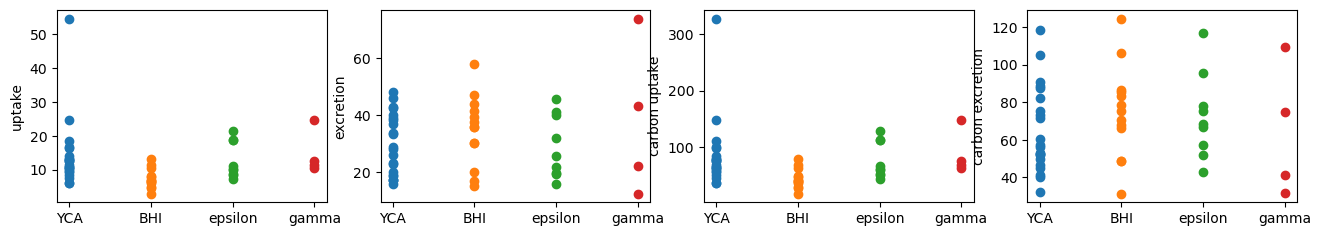

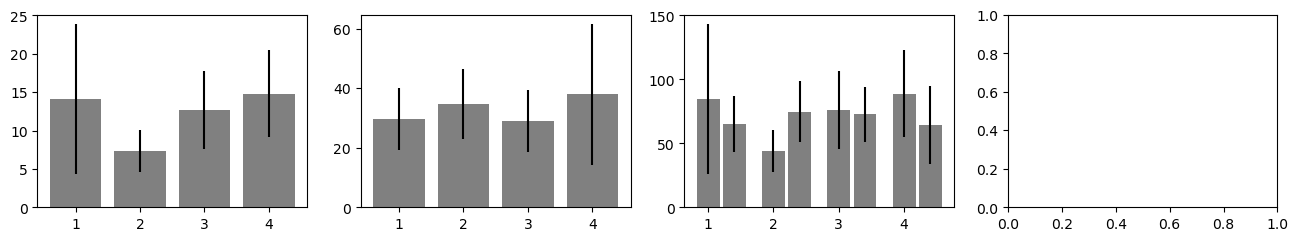

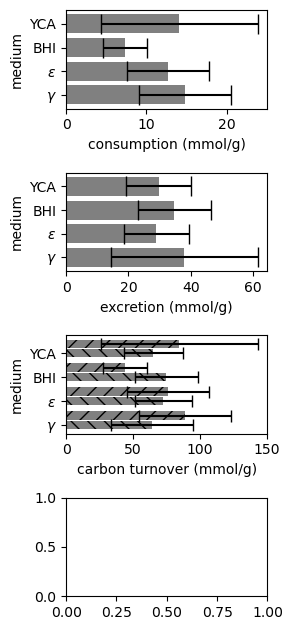

In [30]:
# different media['BHI' 'YCA' 'epsilon plus' 'simple' 'epsilon' 'fecal']
conversionfactor=1/(0.5) #multiply by OD ml/0.5mg to change unti from mM to:   ml mM / mg which is l mM / g which is mmol/g

num_plots=4 #uptake, secetion, different SCFA
fig, ax = plt.subplots(1,num_plots,figsize=(4*num_plots,2.5))
fig2, ax2 = plt.subplots(1,num_plots,figsize=(4*num_plots,2.5)) #bar plots of mean and stdev
fig3, ax3 = plt.subplots(num_plots,1,figsize=(3.,1.6*num_plots)) #bar plots of mean and stdev


conditionlist=[1,2,3,4]
xticklabels=[]
xticks=conditionlist

for cond in conditionlist:
    
    if cond==3: #plot average values for different strains
        
        condname="epsilon"
        exp_numberlist=samplenamelist[media.index("epsilon")][::-1]
    elif cond==4:
        condname="gamma"
        exp_numberlist=samplenamelist[media.index("gamma")][::-1]
    elif cond==2:
        condname="BHI"
        exp_numberlist=samplenamelist[media.index("BHI")][::-1]
    elif cond==1:
        condname="YCA"
        exp_numberlist=samplenamelist[media.index("YCA")][::-1]
    else:
        error
        
    # different media['BHI' 'YCA' 'epsilon plus' 'simple' 'epsilon' 'fecal']
    
    
    xticklabels.append(condname)
    print(condname)
    
    
    datacur=dataout_av.loc[dataout_av["exp_number"].isin(exp_numberlist)]
    datacur=datacur.set_index("exp_number")
    display(datacur)
    
    fontsize=14
    numexp=datacur.shape[0]
    
    
    
    
    strainl=[]
    strainllabelbar=[]
    consumptionl=[]
    excretionl=[]
    energycontentl=[]
    
                    
    excretion_singlel=np.zeros([len(exp_numberlist),8])
    strainlist2=[]
    iS = -1

    mean_ut=[]
    mean_excretion=[]
    mean_ut_c=[]
    mean_excretion_c=[]
    
    for index in exp_numberlist:
                iS = iS+1
                
                straincount=straincount+1
                
                ic = -1
                base=0
                basec=0
                baseut=0
                basecut=0
                energy=0
                
                strainl.append(datacur.at[index,"strain"])
                strainlist2.append(datacur.at[index,"strain"])
                strainllabelbar.append(datacur.at[index,"species"])#+" "+datacur.at[index,"strain"])
                mean_excretion_singlestrain=0
                mean_excretion_singlestrain_c=0
                mean_uptake_singlestrain=0
                mean_uptake_singlestrain_c=0
                consumpc=0
                for sub in sublist:
                    ic=ic+1
                    cfactor=cfactorlist[ic]
                    color=colorlist[ic]
                    if straincount==1:
                        label=sublistshort[ic]
                    else:
                        label=None
                    
                    if sub in ["glucose"]:# and (strainl[-1] not in ["DSM17677","ATCC27255"]):
                        
                        
                        if datacur.at[index,sub]<0:
                            consumpc=consumpc-1*datacur.at[index,sub]*conversionfactor
                            #basecut=basec-cfactor*datacur.at[index,sub]*conversionfactor
                            #baseut=base-datacur.at[index,sub]*conversionfactor
                        #mean_uptake_singlestrain=mean_uptake_singlestrain-conversionfactor*datacur.at[index,sub]
                        #mean_uptake_singlestrain_c=mean_uptake_singlestrain_c-cfactor*conversionfactor*datacur.at[index,sub]
               
                        #inverseyield=-1*baseut*0.18 #mmol/g bacteria *0.18 g glucose /mmol -> gram glucose/gram bacter
                        #excretion_singlel[iS,ic] = -1*datacur.at[index,sub]*conversionfactor
                    
                    elif sub in ["maltose"]: #and (strainl[-1]  in ["DSM17677","ATCC27255"]):
                        
                        #mean_uptake_singlestrain=mean_uptake_singlestrain-conversionfactor*datacur.at[index,sub]
                        #mean_uptake_singlestrain_c=mean_uptake_singlestrain_c-cfactor*conversionfactor*datacur.at[index,sub]
               
                        if datacur.at[index,sub]<0:
                            consumpc=consumpc-2*datacur.at[index,sub]*conversionfactor
                        
                            #basecut=basec-cfactor*datacur.at[index,sub]*conversionfactor
                            #baseut=base-datacur.at[index,sub]*conversionfactor
                        
                        #inverseyield=-1*baseut*0.18 #mmol/g bacteria *0.18 g glucose /mmol -> gram glucose/gram bacter
                        #excretion_singlel[iS,ic] = -1*datacur.at[index,sub]*conversionfactor
                    
                    
                    else:# datacur.at[index,sub]>0.5: #for other fermentation products, require more than 0.5
                        
                        #basec=basec+cfactor*datacur.at[index,sub]*conversionfactor
                        #base=base+datacur.at[index,sub]*conversionfactor
                        #energy=energy+datacur.at[index,sub]*conversionfactor*energycontent[ic] #unit mmol/g *energycontent (unit kcal/mmol)
                        #excretion_singlel[iS,ic] = datacur.at[index,sub]*conversionfactor
                        if datacur.at[index,sub]>0:
                            mean_excretion_singlestrain=mean_excretion_singlestrain+datacur.at[index,sub]*conversionfactor
                            mean_excretion_singlestrain_c=mean_excretion_singlestrain_c+datacur.at[index,sub]*conversionfactor*cfactor
                consumptionl.append(consumpc)
                mean_excretion.append(mean_excretion_singlestrain) 
                mean_excretion_c.append(mean_excretion_singlestrain_c)    
                

    
    consumptionl=np.array(consumptionl)
    mean_excretion=np.array(mean_excretion)
    mean_excretion_c=np.array(mean_excretion_c)
    
    
    ax[0].scatter(consumptionl*0+cond,consumptionl)
    ax[1].scatter(consumptionl*0+cond,mean_excretion)
    ax[2].scatter(consumptionl*0+cond,np.array(consumptionl)*6) #carbon content
    ax[3].scatter(consumptionl*0+cond,mean_excretion_c)
    
    print("condition")
    print(cond)
    print(consumptionl)
    print(mean_excretion)
    
    ax2[0].bar(cond,np.nanmean(consumptionl),yerr=np.nanstd(consumptionl),color='gray')
    ax2[1].bar(cond,np.nanmean(mean_excretion),yerr=np.nanstd(mean_excretion),color='gray')
    ax2[2].bar(cond,np.nanmean(consumptionl)*6,width=0.35,yerr=np.nanstd(consumptionl)*6,color='gray')
    ax2[2].bar(cond+0.4,np.nanmean(mean_excretion_c),width=0.35,yerr=np.nanstd(mean_excretion_c),color='gray')
    
    cond2=5-cond
    hatchconsumption="//"
    hatchexcretion="\\\\"
    colorbar='grey'
    cs=7
    
    cs2=4
    ax3[0].barh(cond2,np.nanmean(consumptionl),xerr=np.nanstd(consumptionl),color=colorbar,capsize=cs)#,hatch=hatchconsumption)
    ax3[1].barh(cond2,np.nanmean(mean_excretion),xerr=np.nanstd(mean_excretion),color=colorbar,capsize=cs)#,hatch=hatchexcretion)
    ax3[2].barh(cond2+0.4,np.nanmean(consumptionl)*6,height=0.35,xerr=np.nanstd(consumptionl)*6,color=colorbar,hatch=hatchconsumption,capsize=cs2)
    ax3[2].barh(cond2,np.nanmean(mean_excretion_c),height=0.35,xerr=np.nanstd(mean_excretion_c),color=colorbar,hatch=hatchexcretion,capsize=cs2)
    for i in [0,1,2]:
        ax3[i].set_yticks([1,2,3,4])
        ax3[i].set_yticklabels(["$\gamma$","$\epsilon$","BHI","YCA"])
        ax3[i].set_ylabel("medium")
    ax3[0].set_xlabel("consumption (mmol/g)")
    ax3[1].set_xlabel("excretion (mmol/g)")
    ax3[2].set_xlabel("carbon turnover (mmol/g)")
  
for i in range(0,num_plots):
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels(xticklabels)

ax[0].set_ylabel("uptake")
ax[1].set_ylabel("excretion")
ax[2].set_ylabel("carbon uptake")
ax[3].set_ylabel("carbon excretion")


plt.tight_layout()
fig.savefig("plot_output_figure1/different_media.pdf")
fig3.savefig("plot_output_figure1/different_media_hbar.pdf")
plt.show()

In [31]:
# plot all data points in one plot vs growth rate

Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  notes     strain   species  \
0               0          40.0        54.0   5.83  ATCC29148   B.theta   
1               1          41.0        53.0   5.95  ATCC29148   B.theta   
2               2          42.0        66.0   6.61  ATCC29148   B.theta   
3               3          43.0        65.0   7.14  ATCC29148   B.theta   
4               4          44.0        52.0   5.63  ATCC29148   B.theta   
..            ...           ...         ...    ...        ...       ...   
101           101           NaN         NaN    NaN   DSM18205   P.copri   
102           102           NaN         NaN    NaN  ATCC27255  R.bromii   
103           103           NaN         NaN    NaN  ATCC27255  R.bromii   
104           104           NaN         NaN    NaN  ATCC27255  R.bromii   
105           105           NaN         NaN    NaN  ATCC27255  R.bromii   

                                  experiment experiment_short  \
0                             Markus_old_Bt6   Markus_old_Bt6   
1                             Markus_old_Bt5   Markus_old_Bt5   
2                             Markus_old_Bt8   Markus_old_Bt8   
3                             Markus_old_Bt7   Markus_old_Bt7   
4                             Markus_old_Bt4   Markus_old_Bt4   
..                                       ...              ...   
101  av [271, 272]_used_only: [181.0, 184.0]               av   
102  av [276, 275]_used_only: [195.0, 202.0]               av   
103  av [284, 283]_used_only: [198.0, 201.0]               av   
104  av [288, 289]_used_only: [199.0, 200.0]               av   
105  av [268, 267]_used_only: [203.0, 205.0]               av   

                      exp_number   medium  ... succinate_std  lactate_std  \
0                             67  epsilon  ...           NaN          NaN   
1                             66  epsilon  ...           NaN          NaN   
2                             79  epsilon  ...           NaN          NaN   
3                             78  epsilon  ...           NaN          NaN   
4                             65  epsilon  ...           NaN          NaN   
..                           ...      ...  ...           ...          ...   
101    av_P.copri_DSM18205_pHvar    pHvar  ...           0.0     1.936116   
102  av_R.bromii_ATCC27255_pHvar    pHvar  ...           0.0    12.607773   
103  av_R.bromii_ATCC27255_pHvar    pHvar  ...           0.0     7.883167   
104  av_R.bromii_ATCC27255_pHvar    pHvar  ...           0.0     0.973011   
105  av_R.bromii_ATCC27255_pHvar    pHvar  ...           0.0     1.855160   

     butyrate_std formate_std maltose_std total_ferm  total_ferm_std  \
0             NaN         NaN         NaN        NaN             NaN   
1             NaN         NaN         NaN        NaN             NaN   
2             NaN         NaN         NaN        NaN             NaN   
3             NaN         NaN         NaN        NaN             NaN   
4             NaN         NaN         NaN        NaN             NaN   
..            ...         ...         ...        ...             ...   
101           0.0    1.378437    0.079488  20.129192        2.436969   
102           0.0   10.429400    0.275197  28.432599        1.935110   
103           0.0   10.183710    0.071507  22.465218        1.615585   
104           0.0    0.011017    0.081993  16.965955        0.648432   
105           0.0    2.252687    0.375684  21.885941        3.224236   

     total_uptake  total_uptake_std  growth_rate_std  
0             NaN               NaN              NaN  
1             NaN               NaN              NaN  
2             NaN               NaN              NaN  
3             NaN               NaN              NaN  
4             NaN               NaN              NaN  
..            ...               ...              ...  
101     -2.158330          0.350564         0.106656  
102     -6.109464          0.539454         0.065613  
103     -5.580873          0.125274   

Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  notes     strain        species  \
73             73           NaN         NaN    NaN  ATCC29148        B.theta   
74             74           NaN         NaN    NaN  ATCC29148        B.theta   
75             75           NaN         NaN    NaN  ATCC29148        B.theta   
76             76           NaN         NaN    NaN  ATCC29148        B.theta   
77             77           NaN         NaN    NaN  ATCC29148        B.theta   
78             78           NaN         NaN    NaN  ATCC29148        B.theta   
79             79           NaN         NaN    NaN   DSM 1447     B.vulgatus   
80             80           NaN         NaN    NaN   DSM 1447     B.vulgatus   
81             81           NaN         NaN    NaN   DSM 1447     B.vulgatus   
82             82           NaN         NaN    NaN   DSM 1447     B.vulgatus   
83             83           NaN         NaN    NaN   DSM 1447     B.vulgatus   
84             84           NaN         NaN    NaN  ATCC33656      E.rectale   
85             85           NaN         NaN    NaN  ATCC33656      E.rectale   
86             86           NaN         NaN    NaN  ATCC33656      E.rectale   
87             87           NaN         NaN    NaN  ATCC33656      E.rectale   
88             88           NaN         NaN    NaN  ATCC33656      E.rectale   
89             89           NaN         NaN    NaN  ATCC33656      E.rectale   
90             90           NaN         NaN    NaN  ATCC33656      E.rectale   
91             91           NaN         NaN    NaN  ATCC33656      E.rectale   
92             92           NaN         NaN    NaN  ATCC33656      E.rectale   
93             93           NaN         NaN    NaN  ATCC33656      E.rectale   
94             94           NaN         NaN    NaN   DSM17677  F.prausnitzii   
95             95           NaN         NaN    NaN   DSM17677  F.prausnitzii   
96             96           NaN         NaN    NaN   DSM17677  F.prausnitzii   
97             97           NaN         NaN    NaN   DSM17677  F.prausnitzii   
98             98           NaN         NaN    NaN   DSM18205        P.copri   
99             99           NaN         NaN    NaN   DSM18205        P.copri   
100           100           NaN         NaN    NaN   DSM18205        P.copri   
101           101           NaN         NaN    NaN   DSM18205        P.copri   
102           102           NaN         NaN    NaN  ATCC27255       R.bromii   
103           103           NaN         NaN    NaN  ATCC27255       R.bromii   
104           104           NaN         NaN    NaN  ATCC27255       R.bromii   
105           105           NaN         NaN    NaN  ATCC27255       R.bromii   

                                            experiment experiment_short  \
73                           av [67]_used_only: [41.0]               av   
74                           av [66]_used_only: [42.0]               av   
75                           av [65]_used_only: [43.0]               av   
76                           av [64]_used_only: [46.0]               av   
77                           av [62]_used_only: [47.0]               av   
78                           av [63]_used_only: [51.0]               av   
79    av [238, 239, 237]_used_only: [71.0, 72.0, 73.0]               av   
80    av [240, 241, 242]_used_only: [74.0, 76.0, 79.0]               av   
81    av [234, 235, 236]_used_only: [75.0, 83.0, 86.0]               av   
82    av [249, 250, 251]_used_only: [77.0, 78.0, 80.0]               av   
83    av [252, 253, 254]_used_only: [81.0, 82.0, 84.0]               av   
84                          av [85]_used_only: [116.0]               av   
85                          av [84]_used_only: [117.0]               av   
86    av [83, 76, 69]_used_only: [122.0, 125.0, 135.0]               av   
87    av [82, 75, 68]_used_only: [123.0, 126.0, 138.0]               av   
88               av [77, 70]_used_only: [124.0, 132.0]               av   
89       

Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  notes     strain        species  \
73             73           NaN         NaN    NaN  ATCC29148        B.theta   
74             74           NaN         NaN    NaN  ATCC29148        B.theta   
75             75           NaN         NaN    NaN  ATCC29148        B.theta   
76             76           NaN         NaN    NaN  ATCC29148        B.theta   
77             77           NaN         NaN    NaN  ATCC29148        B.theta   
78             78           NaN         NaN    NaN  ATCC29148        B.theta   
79             79           NaN         NaN    NaN   DSM 1447     B.vulgatus   
80             80           NaN         NaN    NaN   DSM 1447     B.vulgatus   
81             81           NaN         NaN    NaN   DSM 1447     B.vulgatus   
82             82           NaN         NaN    NaN   DSM 1447     B.vulgatus   
83             83           NaN         NaN    NaN   DSM 1447     B.vulgatus   
84             84           NaN         NaN    NaN  ATCC33656      E.rectale   
85             85           NaN         NaN    NaN  ATCC33656      E.rectale   
86             86           NaN         NaN    NaN  ATCC33656      E.rectale   
87             87           NaN         NaN    NaN  ATCC33656      E.rectale   
88             88           NaN         NaN    NaN  ATCC33656      E.rectale   
89             89           NaN         NaN    NaN  ATCC33656      E.rectale   
90             90           NaN         NaN    NaN  ATCC33656      E.rectale   
91             91           NaN         NaN    NaN  ATCC33656      E.rectale   
92             92           NaN         NaN    NaN  ATCC33656      E.rectale   
93             93           NaN         NaN    NaN  ATCC33656      E.rectale   
94             94           NaN         NaN    NaN   DSM17677  F.prausnitzii   
95             95           NaN         NaN    NaN   DSM17677  F.prausnitzii   
96             96           NaN         NaN    NaN   DSM17677  F.prausnitzii   
97             97           NaN         NaN    NaN   DSM17677  F.prausnitzii   
98             98           NaN         NaN    NaN   DSM18205        P.copri   
99             99           NaN         NaN    NaN   DSM18205        P.copri   
100           100           NaN         NaN    NaN   DSM18205        P.copri   
101           101           NaN         NaN    NaN   DSM18205        P.copri   
102           102           NaN         NaN    NaN  ATCC27255       R.bromii   
103           103           NaN         NaN    NaN  ATCC27255       R.bromii   
104           104           NaN         NaN    NaN  ATCC27255       R.bromii   
105           105           NaN         NaN    NaN  ATCC27255       R.bromii   

                                            experiment experiment_short  \
73                           av [67]_used_only: [41.0]               av   
74                           av [66]_used_only: [42.0]               av   
75                           av [65]_used_only: [43.0]               av   
76                           av [64]_used_only: [46.0]               av   
77                           av [62]_used_only: [47.0]               av   
78                           av [63]_used_only: [51.0]               av   
79    av [238, 239, 237]_used_only: [71.0, 72.0, 73.0]               av   
80    av [240, 241, 242]_used_only: [74.0, 76.0, 79.0]               av   
81    av [234, 235, 236]_used_only: [75.0, 83.0, 86.0]               av   
82    av [249, 250, 251]_used_only: [77.0, 78.0, 80.0]               av   
83    av [252, 253, 254]_used_only: [81.0, 82.0, 84.0]               av   
84                          av [85]_used_only: [116.0]               av   
85                          av [84]_used_only: [117.0]               av   
86    av [83, 76, 69]_used_only: [122.0, 125.0, 135.0]               av   
87    av [82, 75, 68]_used_only: [123.0, 126.0, 138.0]               av   
88               av [77, 70]_used_only: [124.0, 132.0]               av   
89       

Text(0, 0.5, 'fermentation products (mmol/OD)')

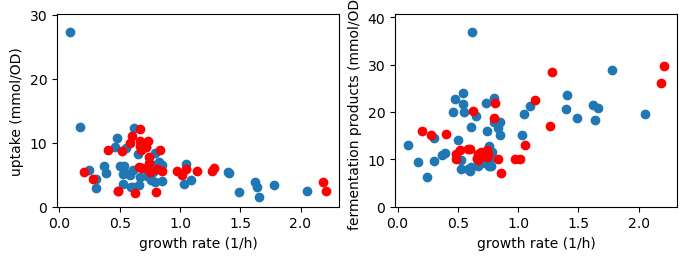

In [32]:
dataout_av_ph=pd.read_csv("data_hplc/analysis_out_av_pHdata.csv")
dataout_av=pd.read_csv("data_hplc/analysis_out_av.csv")
display(dataout_av_ph)

select=dataout_av.loc[dataout_av["experiment_short"]=="av"]
select_ph=dataout_av_ph.loc[dataout_av_ph["experiment_short"]=="av"]


display(select_ph)
#display(select.columns)

#display(speciesinformation.head())

conversionfactor=1/(0.5) #multiply by OD ml/0.5mg to change unti from mM to:   ml mM / mg which is l mM / g which is mmol/g

num_plots=4 #uptake, secetion, different SCFA
fig, ax = plt.subplots(1,2,figsize=(2*num_plots,2.5))

x=np.linspace(0,2,100)
ax[0].plot(select["growth_rate"],-1*select["total_uptake"],ls='',marker='o')
ax[0].set_ylim(0,1.1*np.max(-1*select["total_uptake"]))
fit=np.polyfit(select["growth_rate"],-1*select["total_uptake"],1)
#ax[0].plot(x,x*fit[0]+fit[1],ls='--',c='k')



ax[1].plot(select["growth_rate"],select["total_ferm"],ls='',marker='o')
ax[1].set_ylim(0,1.1*np.max(select["total_ferm"]))
fit=np.polyfit(select["growth_rate"],select["total_ferm"],1)
#ax[1].plot(x,x*fit[0]+fit[1],ls='--',c='k')

#add pH

display(select_ph)
ax[0].plot(select_ph["growth_rate"],-1*select_ph["total_uptake"],ls='',marker='o',color='r')
ax[1].plot(select_ph["growth_rate"],select_ph["total_ferm"],ls='',marker='o',color='r')


#labels
ax[0].set_xlabel("growth rate (1/h)")
ax[1].set_xlabel("growth rate (1/h)")
ax[0].set_ylabel("uptake (mmol/OD)")
ax[1].set_ylabel("fermentation products (mmol/OD)")

